# Libraries

In [1]:
#!/usr/bin/env python3
# encoding: utf-8
import warnings
import os
warnings.filterwarnings("ignore")
import sys

from utilSD import per_missing, var_unicos, corr_top, corr_detail, crear_dummies, evaluar_rf

In [2]:
# Otras librerias 
import traceback
import logging
import pandas as pd
import numpy as np
import time
import datetime as dt
import dateutil.relativedelta
from datetime import timedelta,datetime,date,timedelta
import configparser
from scipy import stats

import matplotlib.pyplot as plt
import seaborn as sns 

In [3]:
%matplotlib inline
pd.options.display.max_rows = 999

# EDA DS Challenge

## Read Raw

In [4]:
Data_raw = pd.read_csv("..\data\ds_challenge_2021.csv", sep=",")
Data_raw.sample(2)

,ID_USER,genero,monto,fecha,hora,dispositivo,establecimiento,ciudad,tipo_tc,linea_tc,interes_tc,status_txn,is_prime,dcto,cashback,fraude
21698,3210,M,339.205991,2020-01-18,18,"{'model': 2020, 'device_score': 1, 'os': '.'}",NaN,NaN,Virtual,39000,46,Aceptada,False,33.920599,6.105708,False
20473,3014,F,175.672402,2020-01-20,5,"{'model': 2020, 'device_score': 3, 'os': 'WEB'}",NaN,Monterrey,Virtual,99000,45,Aceptada,False,0.000000,3.513448,False


In [5]:
per_missing(Data_raw)

,0,1
ciudad,11678,43.291937
establecimiento,10119,37.512512
ID_USER,0,0.000000
genero,0,0.000000
monto,0,0.000000
fecha,0,0.000000
hora,0,0.000000
dispositivo,0,0.000000
tipo_tc,0,0.000000
linea_tc,0,0.000000


In [6]:
Data_raw.dtypes

ID_USER              int64
genero              object
monto              float64
fecha               object
hora                 int64
dispositivo         object
establecimiento     object
ciudad              object
tipo_tc             object
linea_tc             int64
interes_tc           int64
status_txn          object
is_prime              bool
dcto               float64
cashback           float64
fraude                bool
dtype: object

In [7]:
Data_raw['fraude'] = Data_raw['fraude'].astype(int)
Data_raw['is_prime'] = Data_raw['is_prime'].astype(int)

In [8]:
Data_raw['dispositivo'].value_counts(dropna=False)

{'model': 2020, 'device_score': 4, 'os': '%%'}         1411
{'model': 2020, 'device_score': 1, 'os': 'WEB'}        1388
{'model': 2020, 'device_score': 5, 'os': 'WEB'}        1377
{'model': 2020, 'device_score': 2, 'os': '.'}          1374
{'model': 2020, 'device_score': 5, 'os': 'ANDROID'}    1372
{'model': 2020, 'device_score': 2, 'os': '%%'}         1370
{'model': 2020, 'device_score': 2, 'os': 'WEB'}        1358
{'model': 2020, 'device_score': 3, 'os': '.'}          1355
{'model': 2020, 'device_score': 1, 'os': '%%'}         1355
{'model': 2020, 'device_score': 4, 'os': 'WEB'}        1354
{'model': 2020, 'device_score': 5, 'os': '%%'}         1348
{'model': 2020, 'device_score': 1, 'os': 'ANDROID'}    1344
{'model': 2020, 'device_score': 4, 'os': 'ANDROID'}    1335
{'model': 2020, 'device_score': 4, 'os': '.'}          1335
{'model': 2020, 'device_score': 5, 'os': '.'}          1334
{'model': 2020, 'device_score': 3, 'os': '%%'}         1324
{'model': 2020, 'device_score': 3, 'os':

In [9]:
dispositivo_json_cols = list(eval(Data_raw['dispositivo'].loc[0]).keys())
dispositivo_json_cols

['model', 'device_score', 'os']

In [10]:
list_data = list(Data_raw['dispositivo'].apply( lambda x: list( map(lambda x:str(x),list(eval(x).values()))) ) )
Data_raw.loc[:,dispositivo_json_cols] = pd.DataFrame(list_data,columns = dispositivo_json_cols)

In [11]:
Data_raw.drop(['dispositivo'], axis=1, inplace=True)
Data_raw.drop(['model'], axis=1, inplace=True)
Data_raw.drop(['ID_USER'], axis=1, inplace=True)
Data_raw.sample(2)

,genero,monto,fecha,hora,establecimiento,ciudad,tipo_tc,linea_tc,interes_tc,status_txn,is_prime,dcto,cashback,fraude,device_score,os
25727,F,241.829995,2020-01-28,14,NaN,Monterrey,Física,43000,35,Aceptada,0,0.00000,2.418300,0,1,ANDROID
3929,F,69.423203,2020-01-23,5,NaN,Monterrey,Física,30000,63,En proceso,0,6.94232,0.624809,0,1,WEB


In [12]:
aux = var_unicos(Data_raw)
aux

,index,Unicos,Tipo
6,tipo_tc,2,object
10,is_prime,2,int32
13,fraude,2,int32
0,genero,3,object
9,status_txn,3,object
15,os,4,object
5,ciudad,5,object
14,device_score,5,object
4,establecimiento,6,object
3,hora,23,int64


In [14]:
Data_raw['fecha'] = pd.to_datetime(Data_raw['fecha'])
Data_raw['dia'] = Data_raw['fecha'].dt.dayofweek
Data_raw = Data_raw.drop(["fecha"], axis=1)

In [15]:
weekDays = ["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"]
Data_raw['dia_name'] = Data_raw['dia'].map(lambda x : weekDays[x] )

In [16]:
Data_raw.sample(3)

,genero,monto,hora,establecimiento,ciudad,tipo_tc,linea_tc,interes_tc,status_txn,is_prime,dcto,cashback,fraude,device_score,os,dia,dia_name
1687,F,233.875237,13,Restaurante,NaN,Virtual,68000,56,Aceptada,0,0.000000,4.677505,0,2,%%,5,Saturday
24061,M,741.186241,10,MPago,NaN,Física,95000,57,En proceso,0,74.118624,6.670676,0,1,WEB,5,Saturday
433,M,686.939417,23,NaN,Toluca,Física,41000,42,Aceptada,0,0.000000,6.869394,0,5,%%,5,Saturday


In [17]:
Data_raw['establecimiento'] = Data_raw['establecimiento'].fillna('No_definido')
Data_raw['ciudad'] = Data_raw['ciudad'].fillna('No_definido')
Data_raw['genero'] = Data_raw['genero'].replace({ "--" : "No_definido"})
Data_raw['os'] = Data_raw['os'].replace({ "%%" : "PERCENT" , "." : "POINT" })

In [18]:
Data_raw['fraude'].value_counts(dropna=False)

0    26165
1      810
Name: fraude, dtype: int64

In [19]:
target = 'fraude'
aux_unique = var_unicos(Data_raw)

for col in aux_unique[aux_unique['Unicos']<30]['index'].to_list():
    print(col)
    aux = pd.concat([Data_raw[col].value_counts(dropna=False).rename("#").sort_index(),
                    Data_raw.groupby([col], dropna=False)[target].sum().rename("T").sort_index(),
                    Data_raw[col].value_counts(dropna=False, normalize=True).rename("per").sort_index()],axis=1)
    aux["Per_A"]=aux['per'].cumsum(axis=0)
    aux["per_T"]=aux['T']/aux['#']
    aux["per_T_Total"]=aux['T']/(aux['T'].sum())
    aux["Per_Tg_A"]=aux['per_T_Total'].cumsum(axis=0)
    print(aux)
    print("-------------------------------------------------")

fraude
       #    T       per     Per_A  per_T  per_T_Total  Per_Tg_A
0  26165    0  0.969972  0.969972    0.0          0.0       0.0
1    810  810  0.030028  1.000000    1.0          1.0       1.0
-------------------------------------------------
is_prime
       #    T       per     Per_A     per_T  per_T_Total  Per_Tg_A
0  23416  710  0.868063  0.868063  0.030321     0.876543  0.876543
1   3559  100  0.131937  1.000000  0.028098     0.123457  1.000000
-------------------------------------------------
tipo_tc
             #    T      per    Per_A     per_T  per_T_Total  Per_Tg_A
Física   18903  579  0.70076  0.70076  0.030630     0.714815  0.714815
Virtual   8072  231  0.29924  1.00000  0.028617     0.285185  1.000000
-------------------------------------------------
genero
                 #    T       per     Per_A     per_T  per_T_Total  Per_Tg_A
F            10726  334  0.397627  0.397627  0.031139     0.412346  0.412346
M            13519  388  0.501168  0.898795  0.028700     0

In [20]:
#import dtale
#dtale.show(Data_raw)

In [22]:
col_categoricos = aux_unique[aux_unique['Unicos']<30]['index'].tolist()
col_num = aux_unique[aux_unique['Unicos']>=30]['index'].tolist()

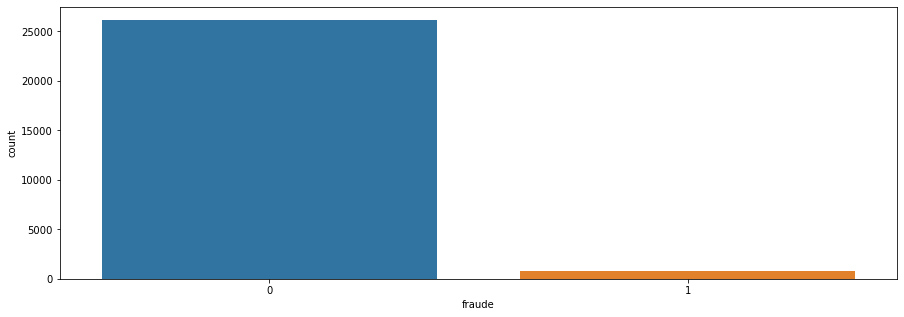

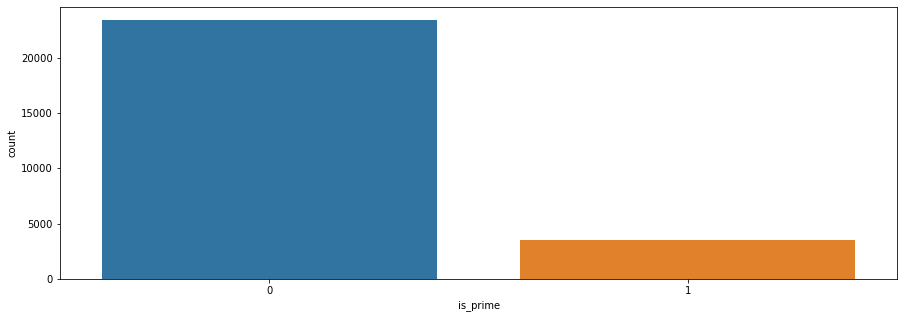

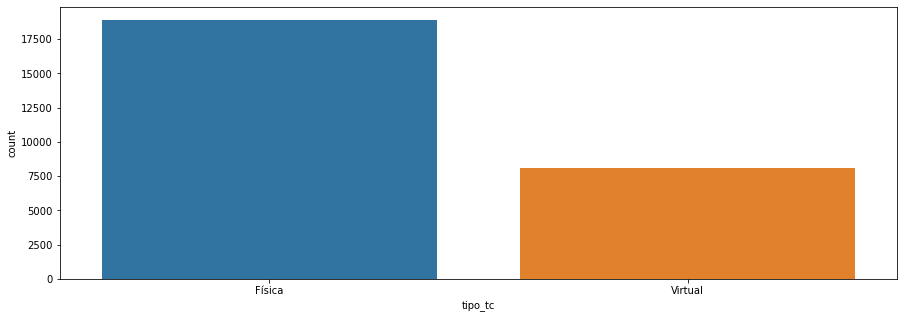

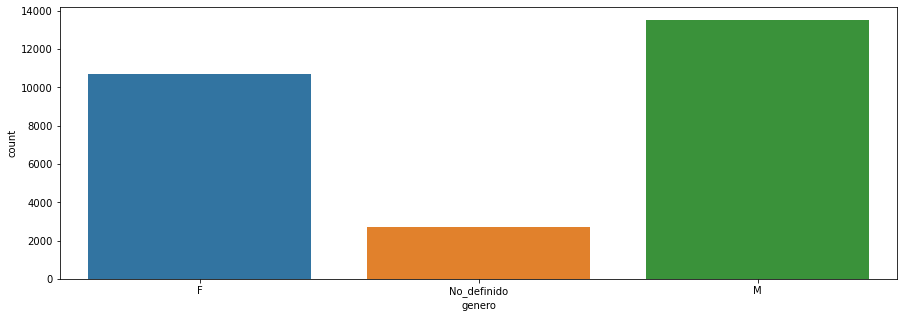

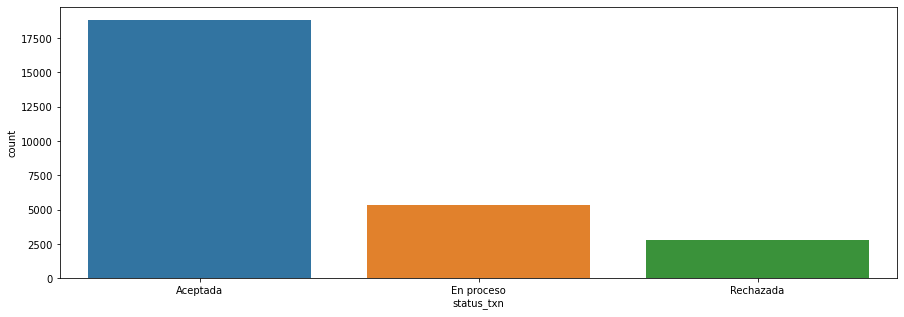

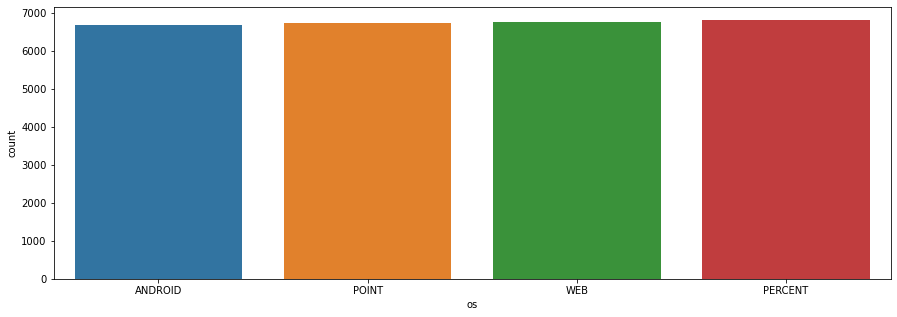

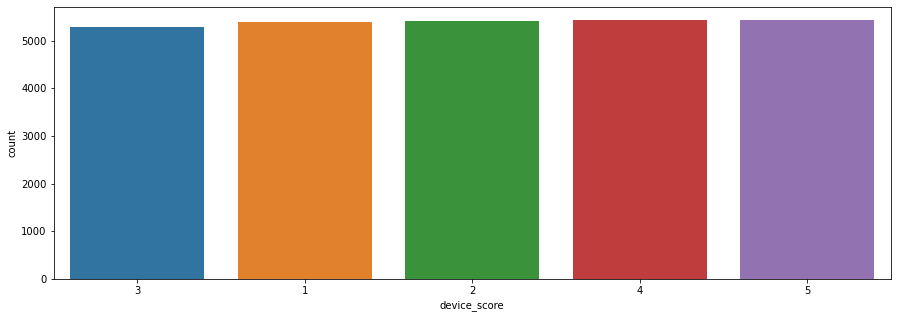

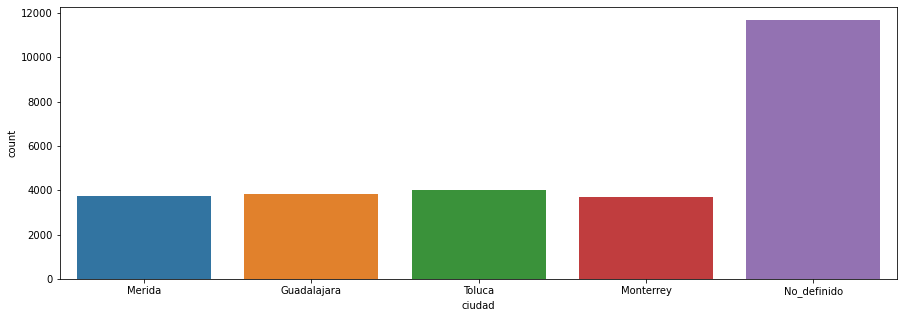

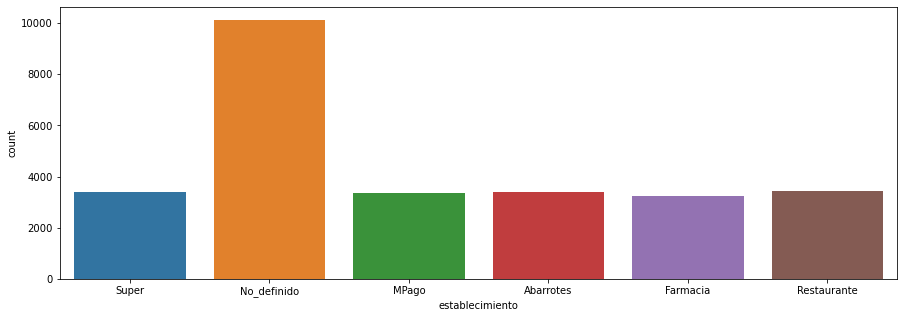

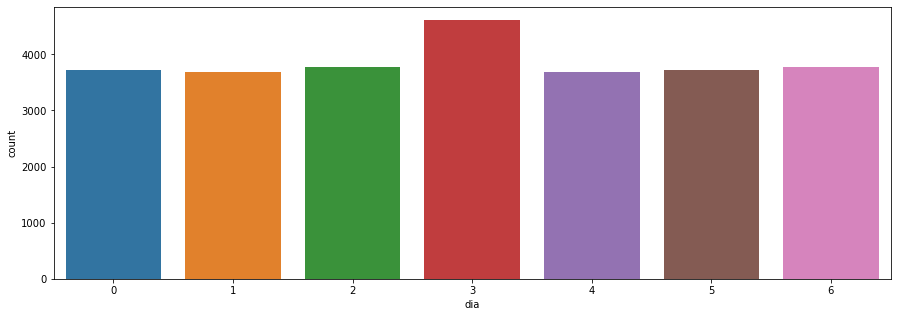

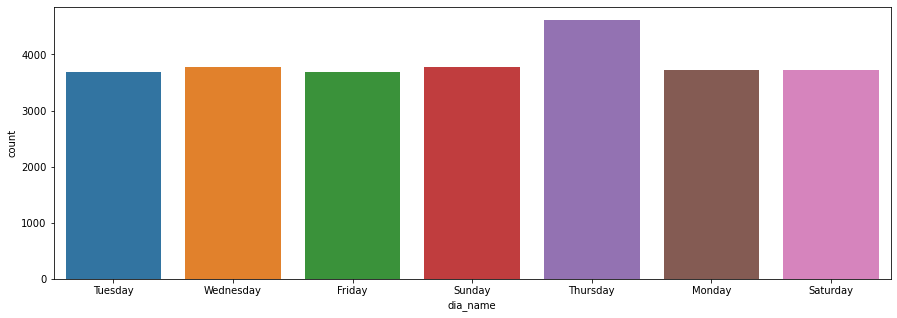

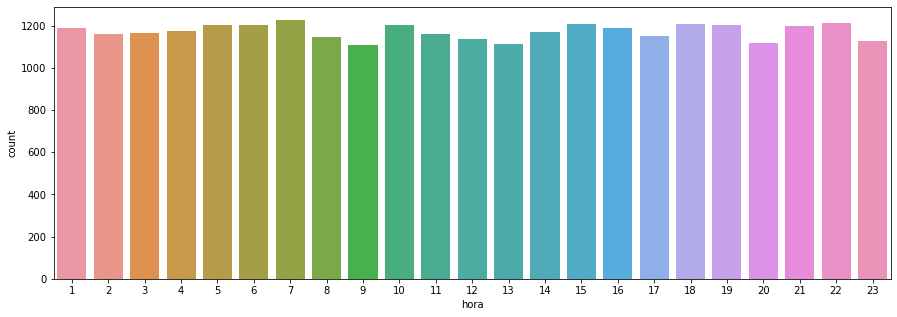

In [23]:
for col in col_categoricos:
    plt.subplots(figsize=(15, 5))
    sns.countplot(x=col,data=Data_raw)

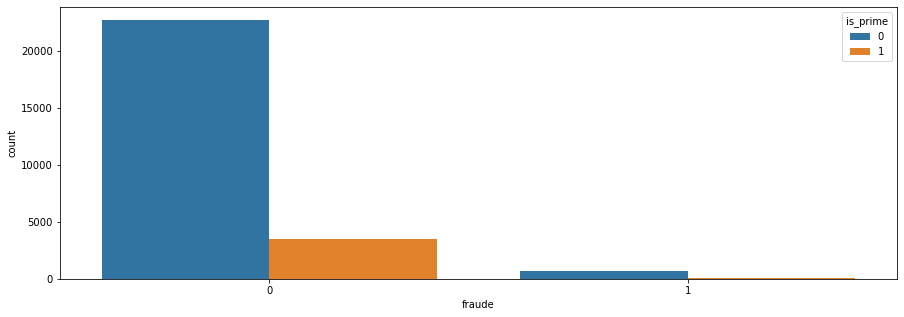

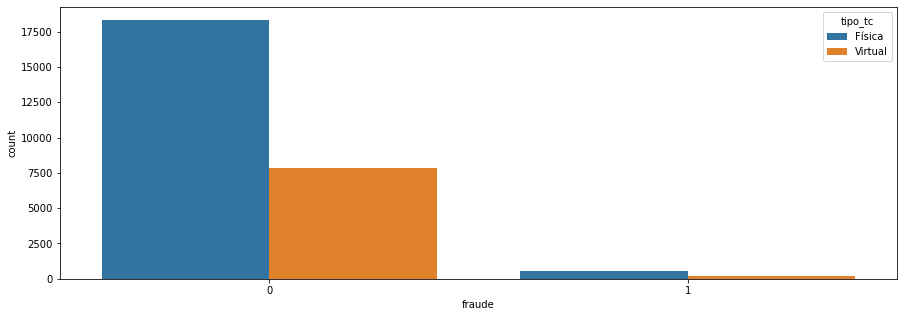

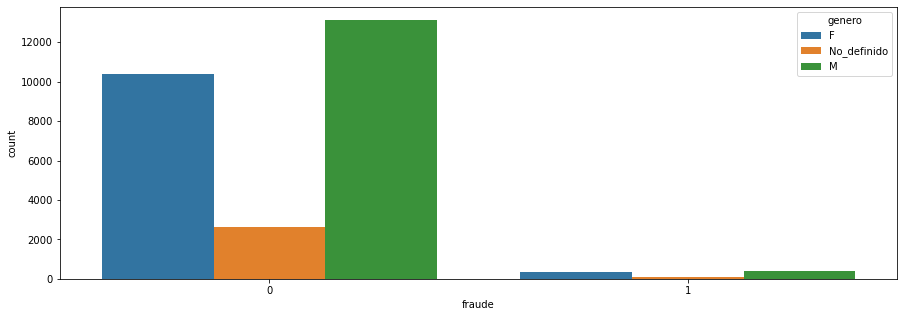

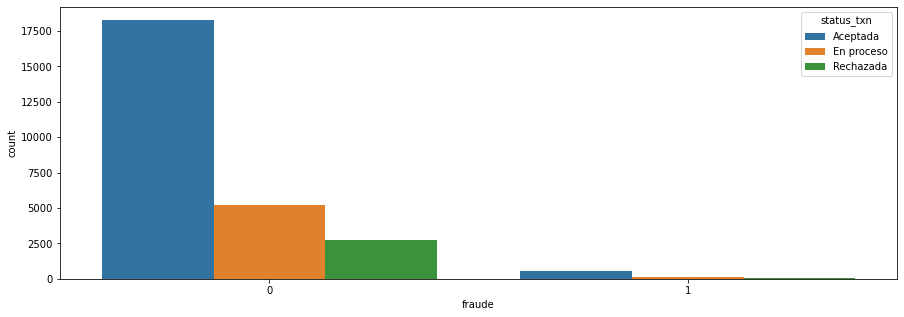

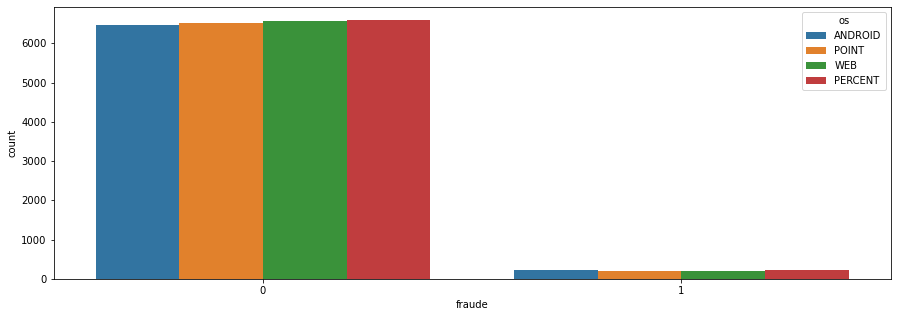

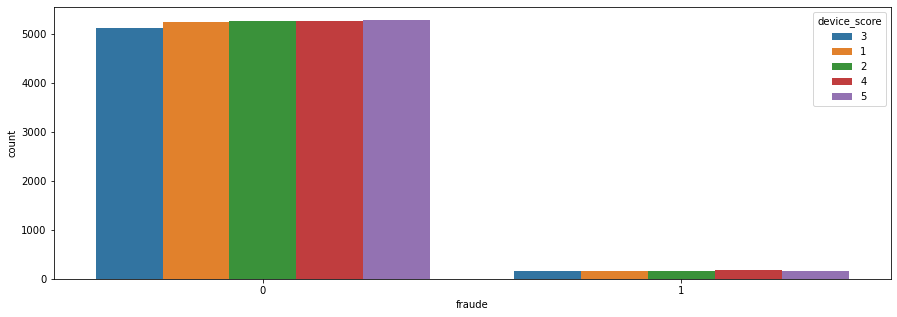

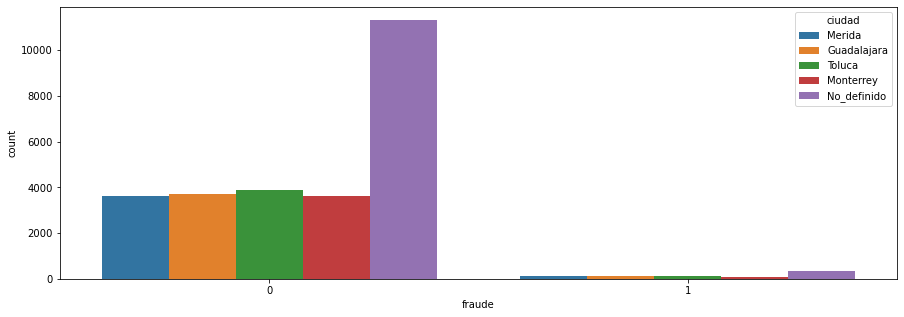

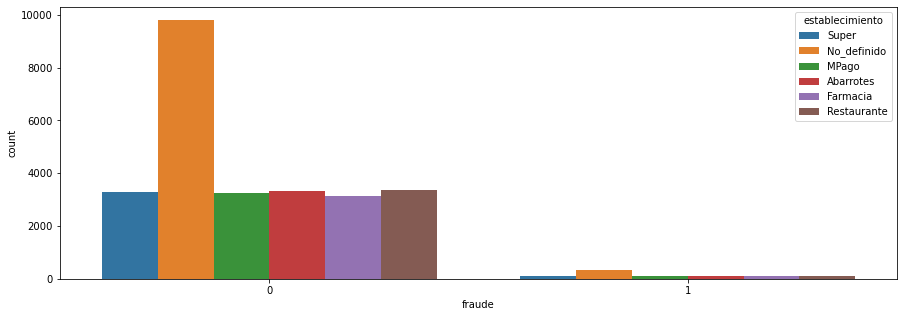

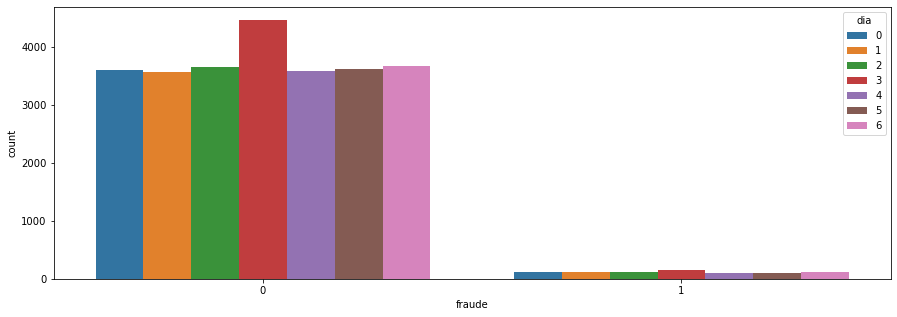

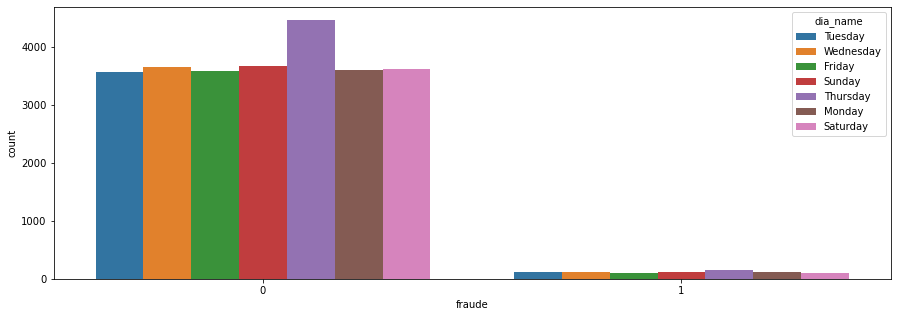

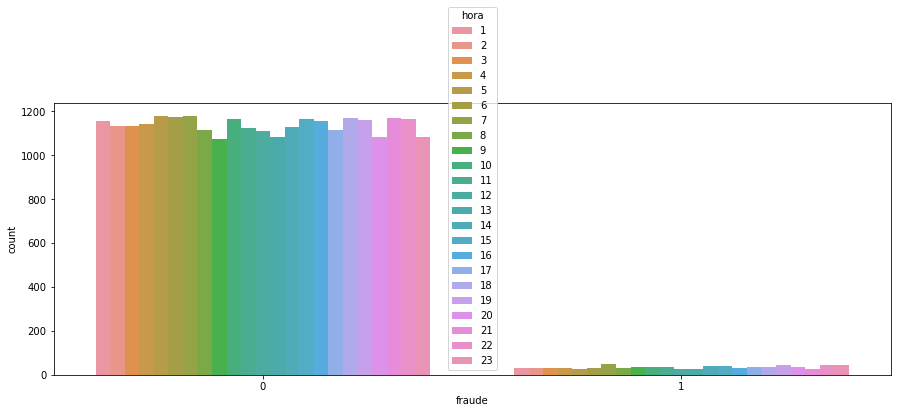

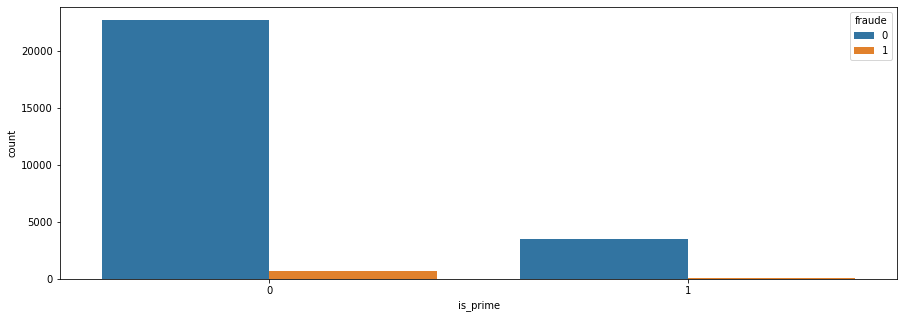

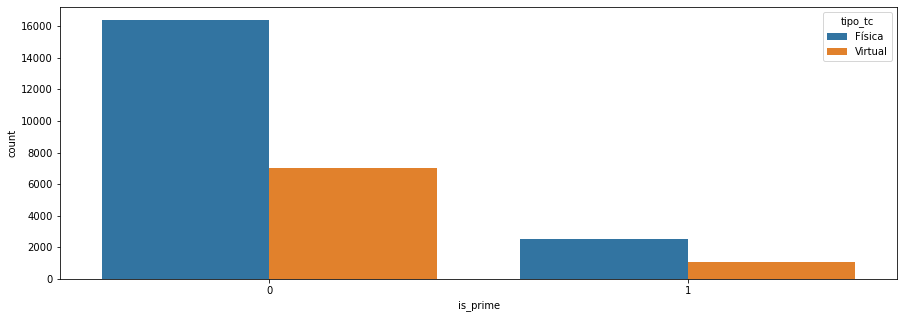

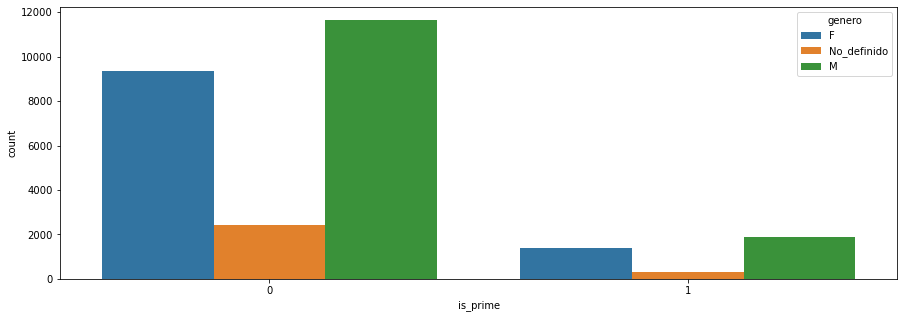

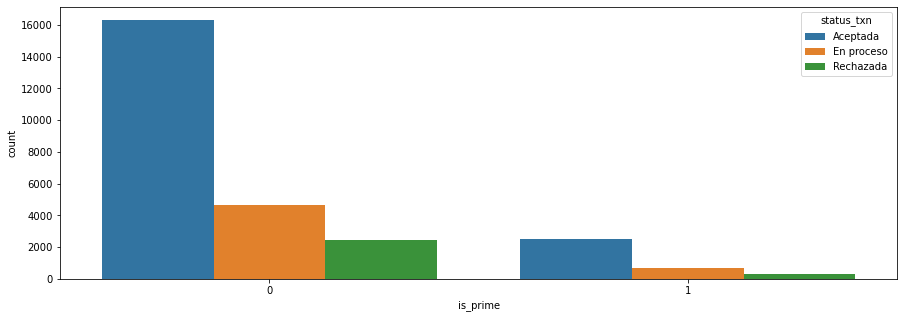

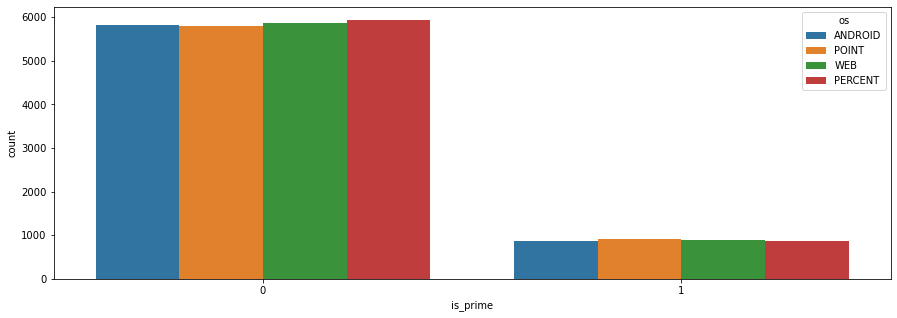

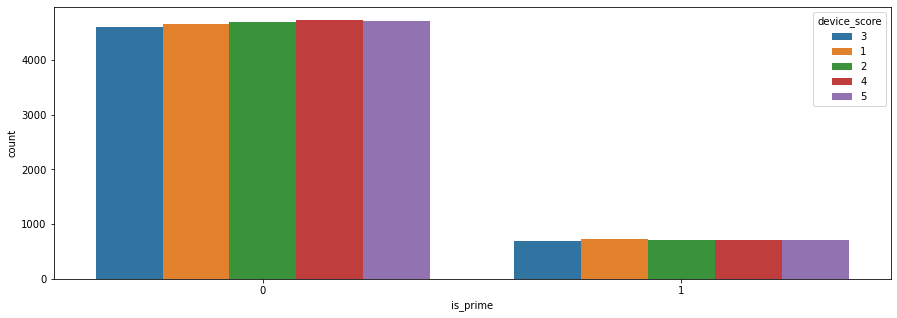

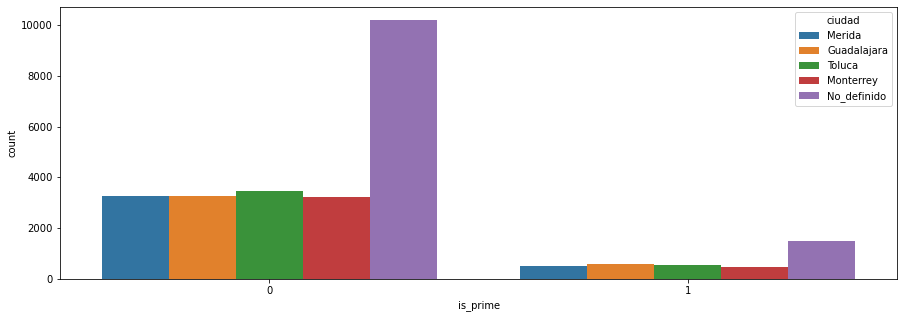

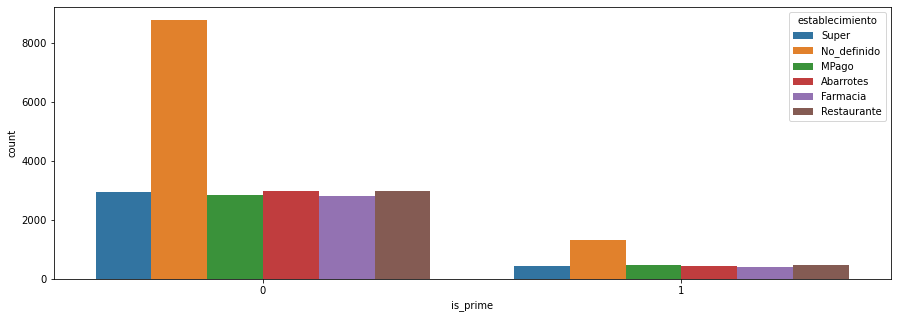

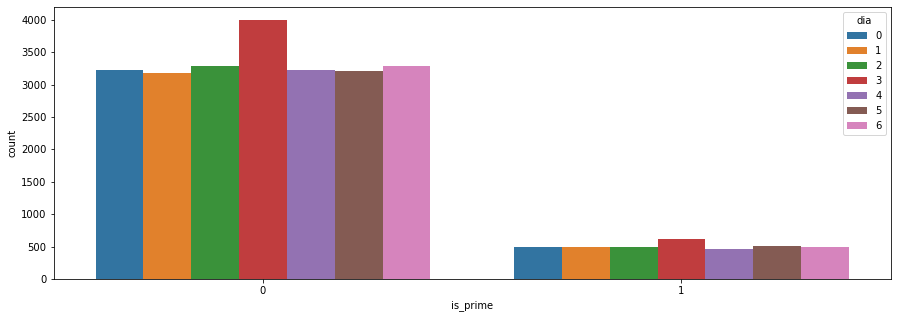

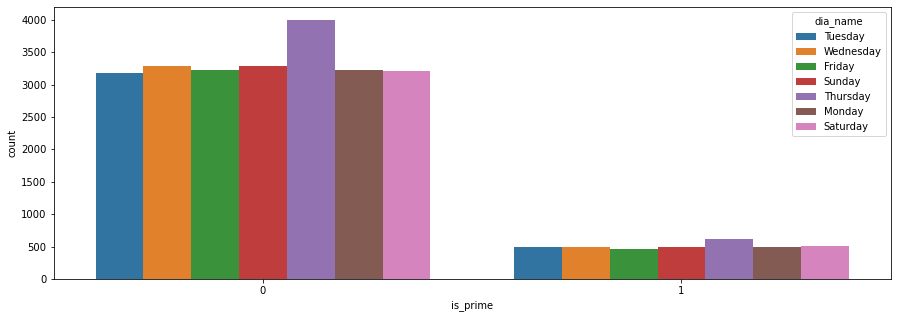

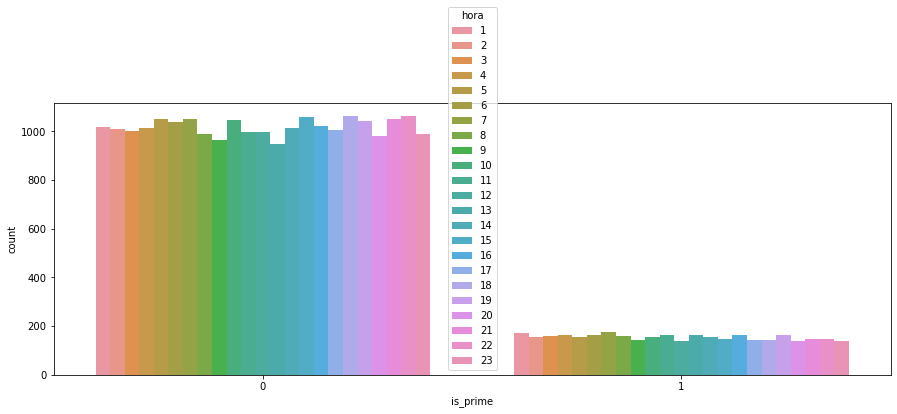

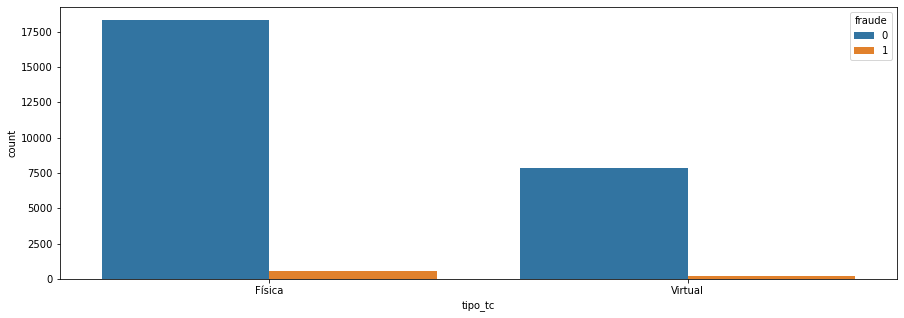

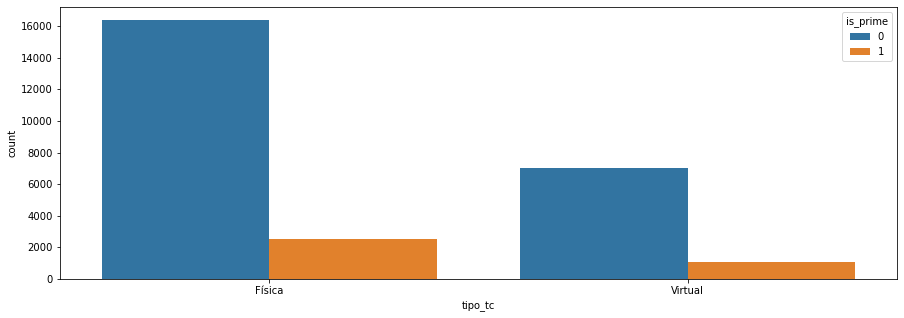

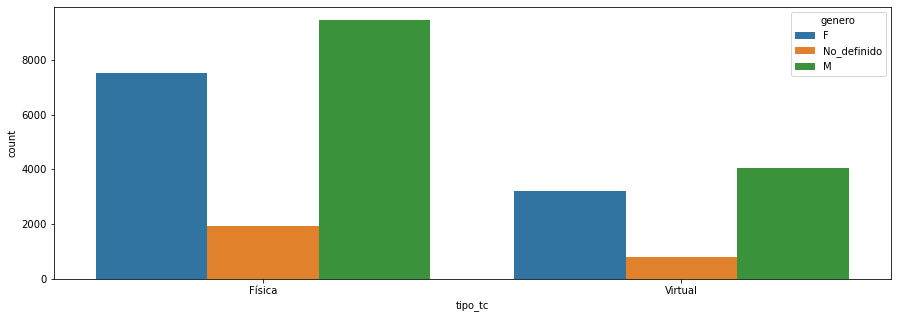

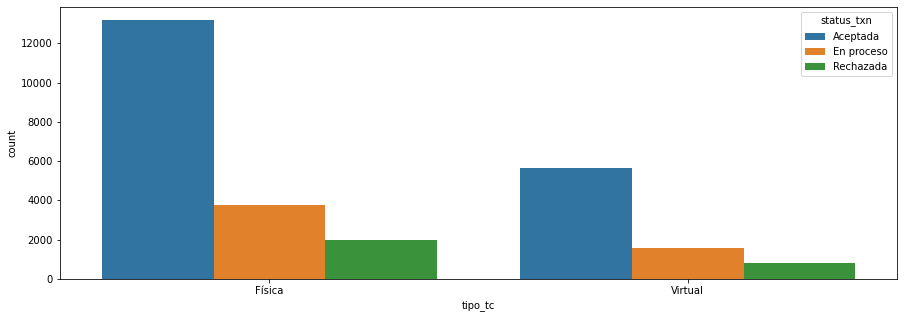

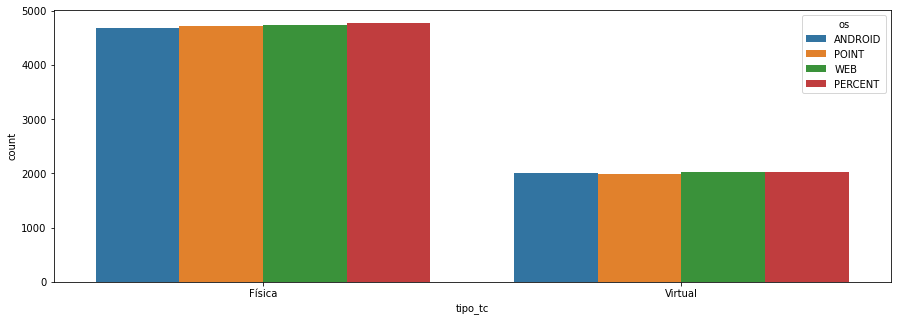

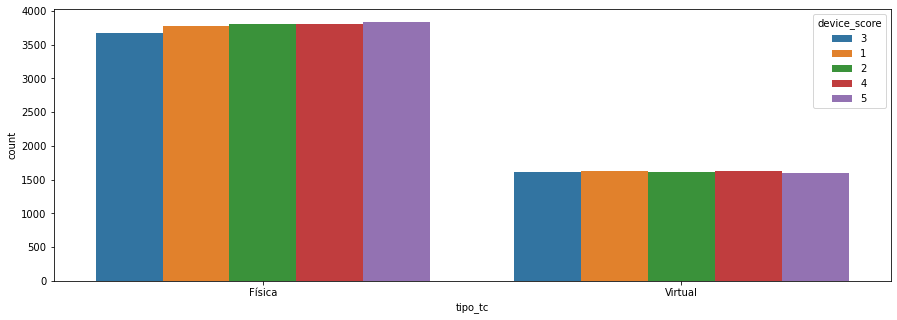

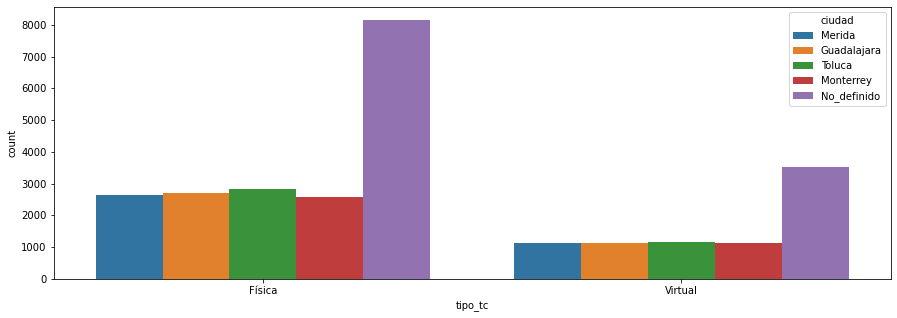

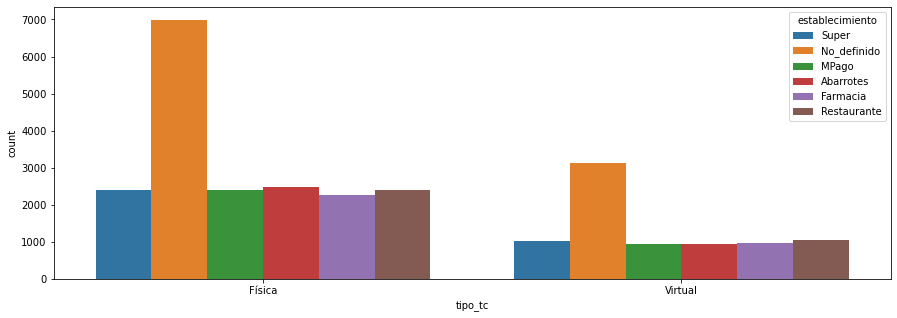

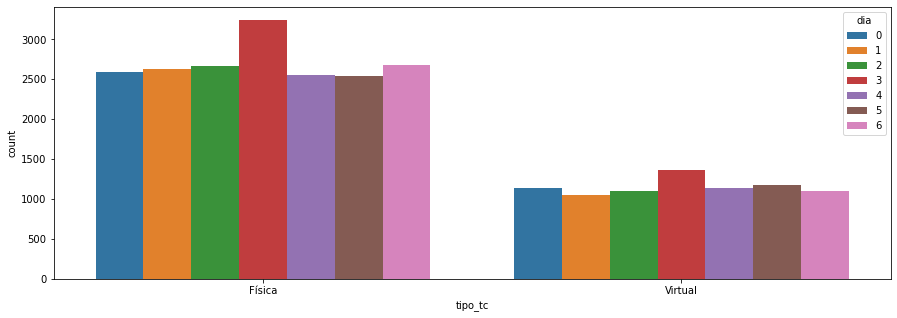

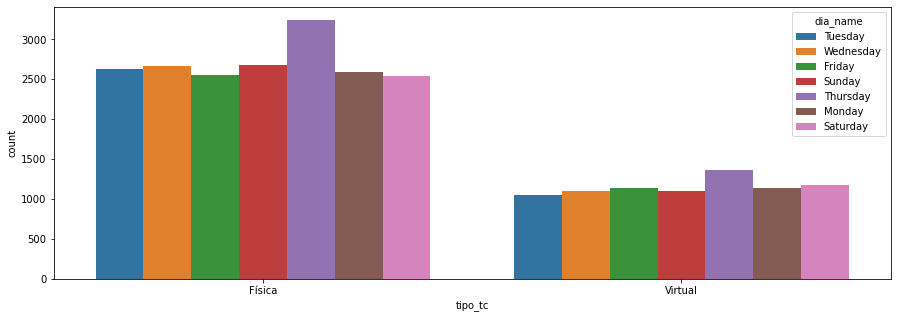

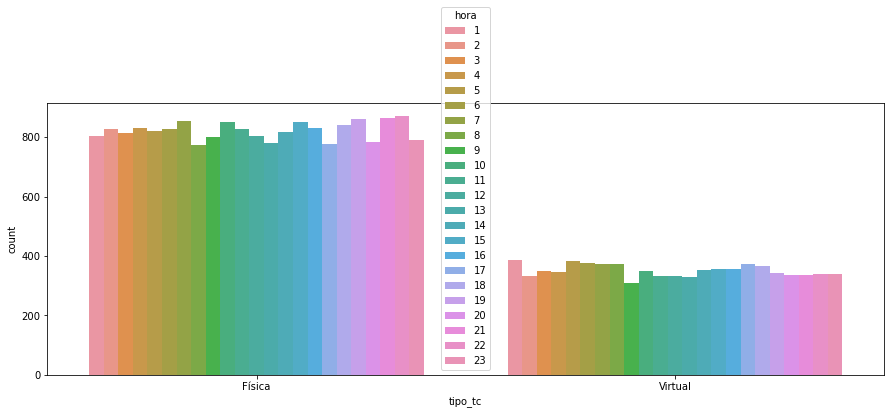

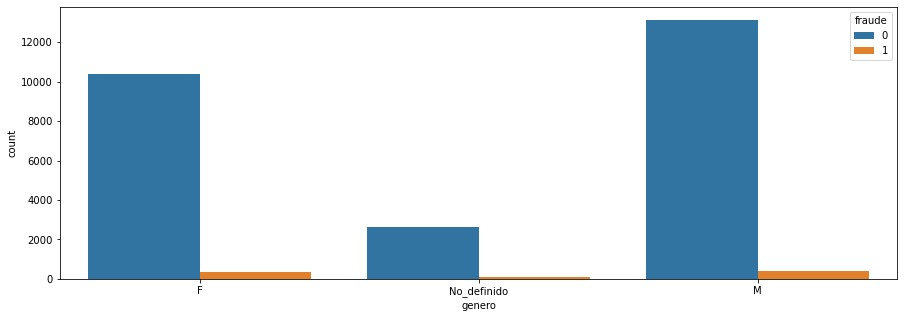

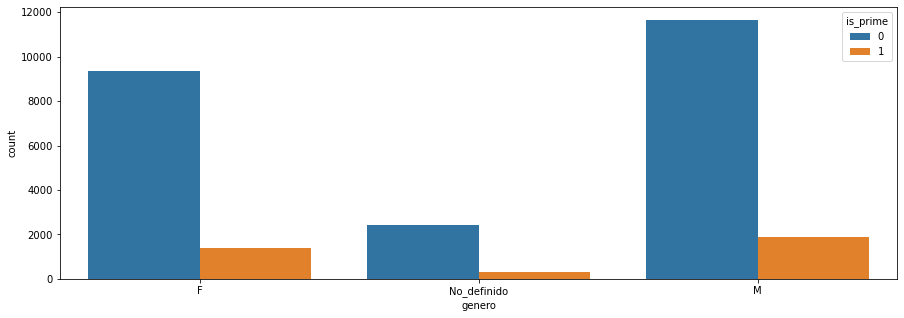

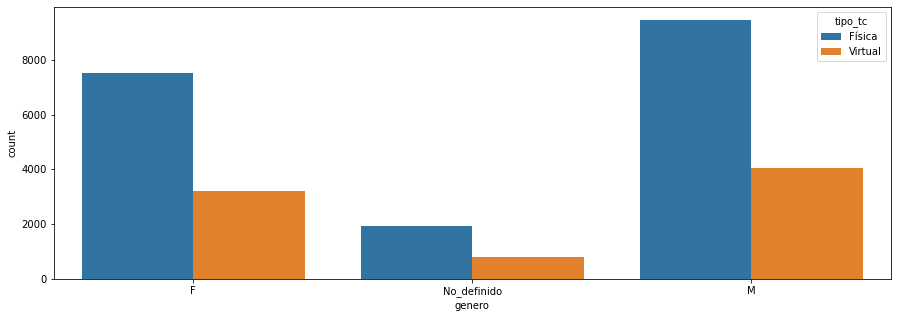

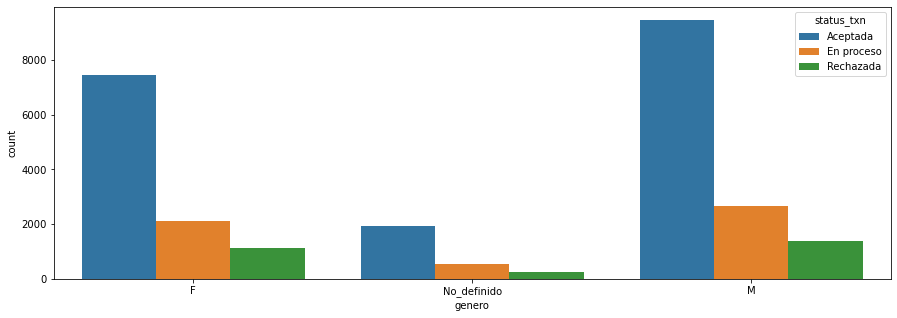

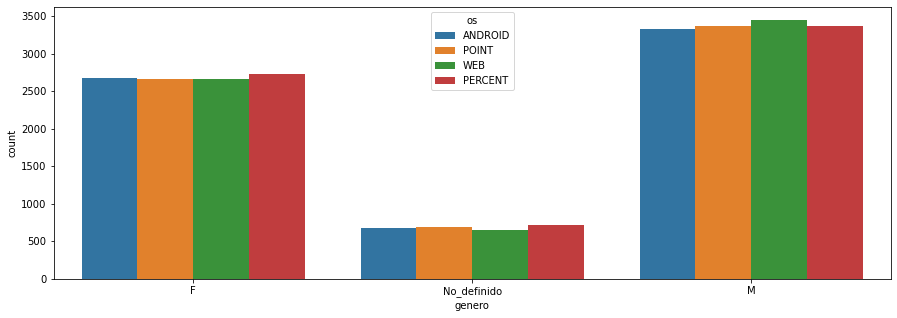

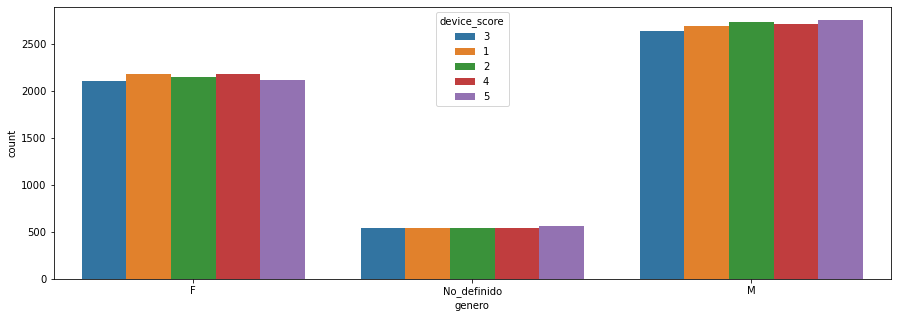

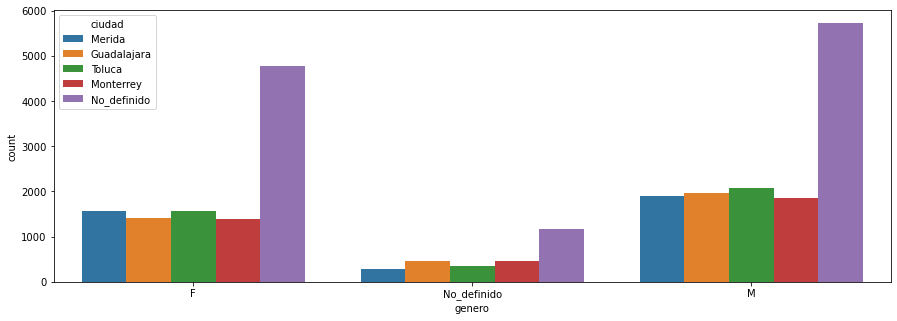

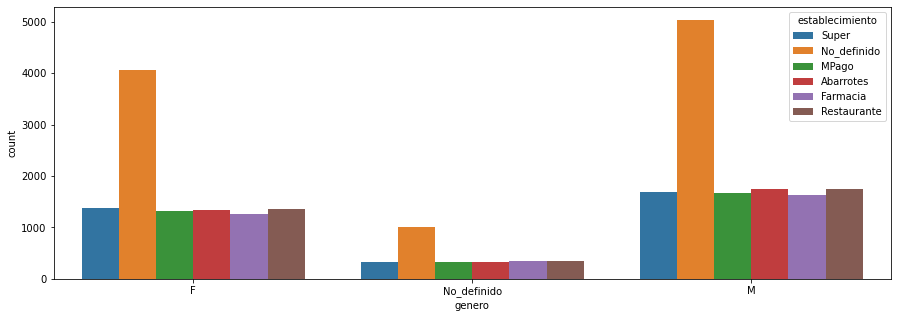

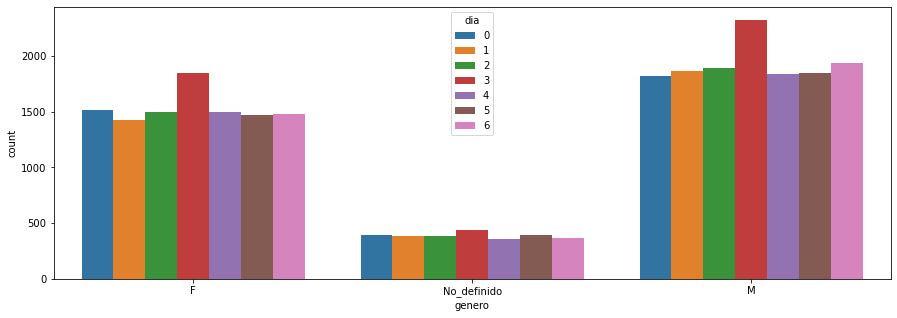

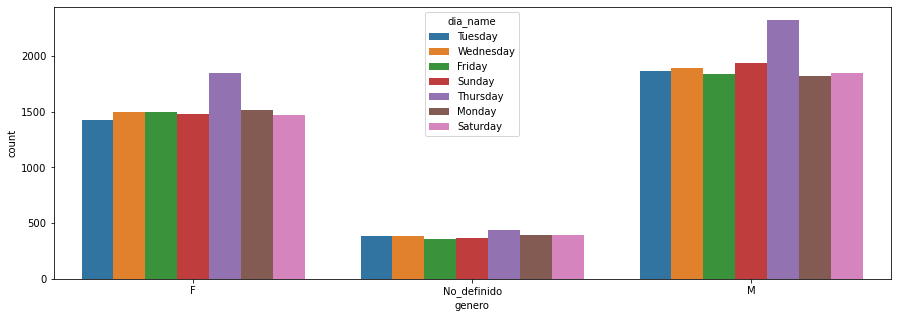

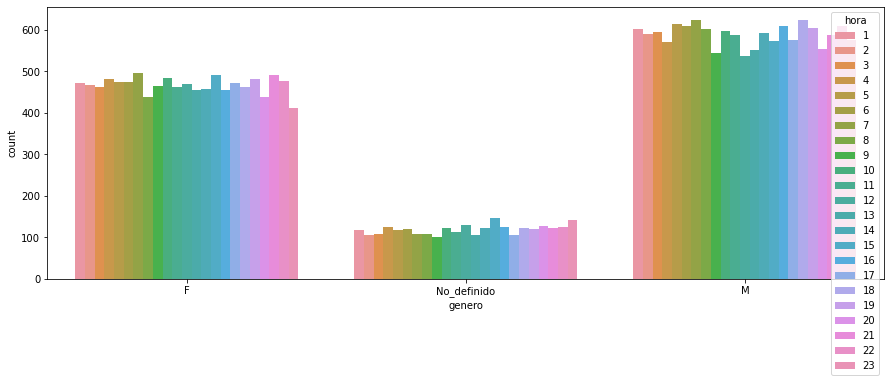

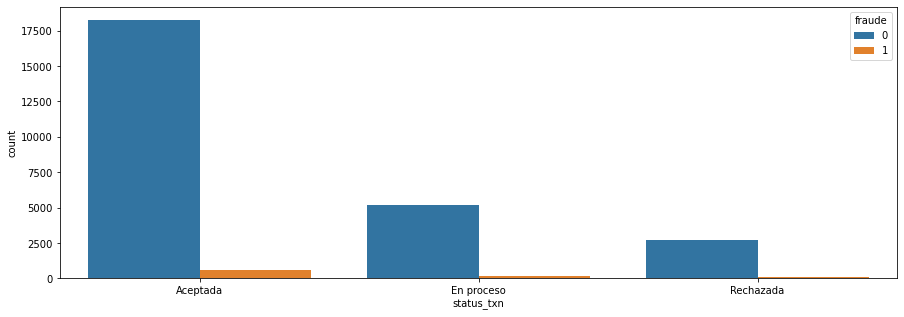

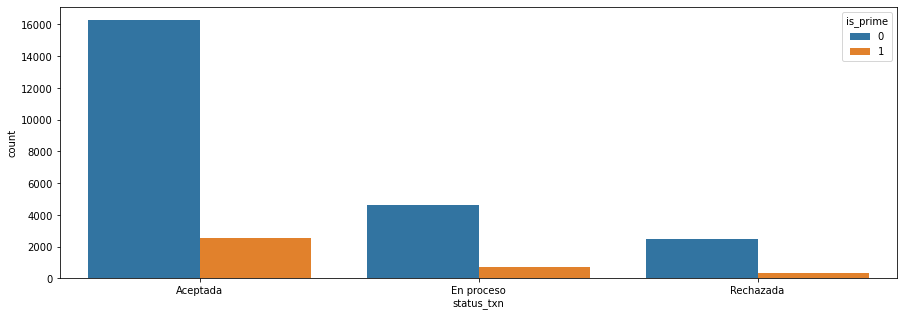

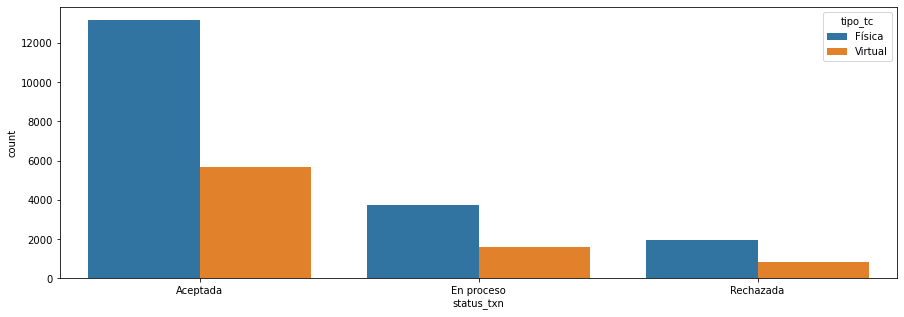

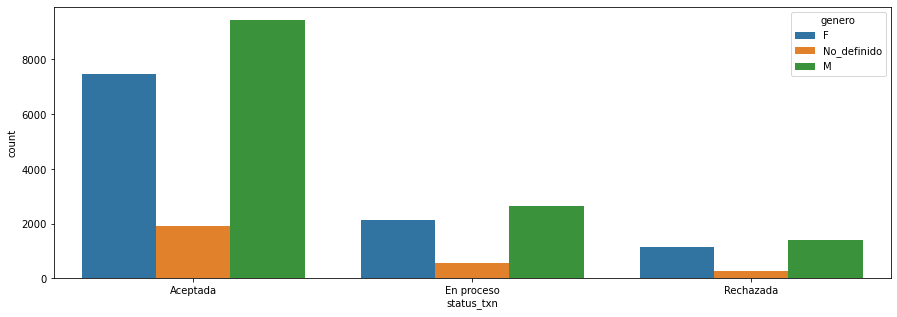

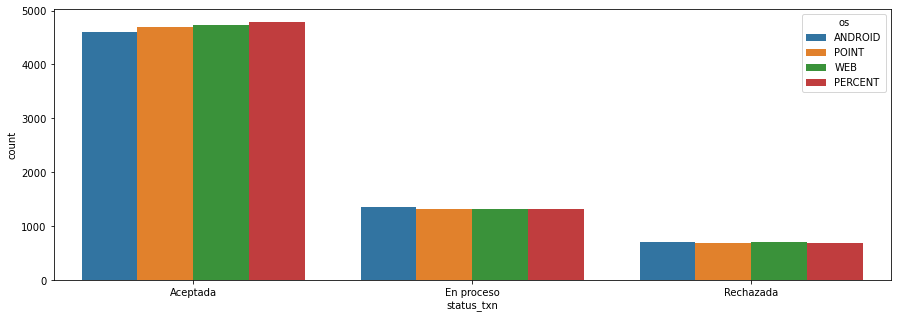

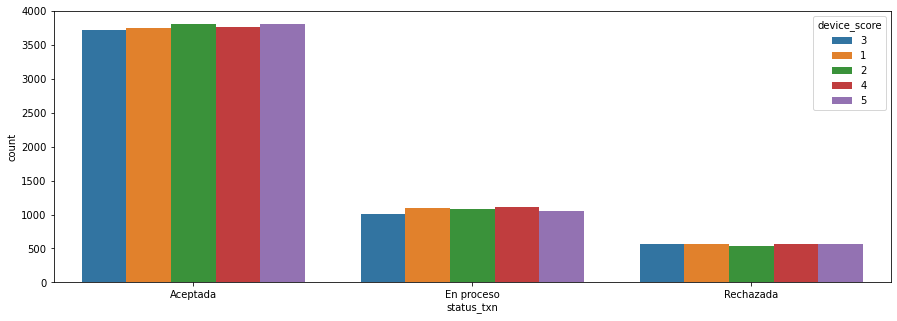

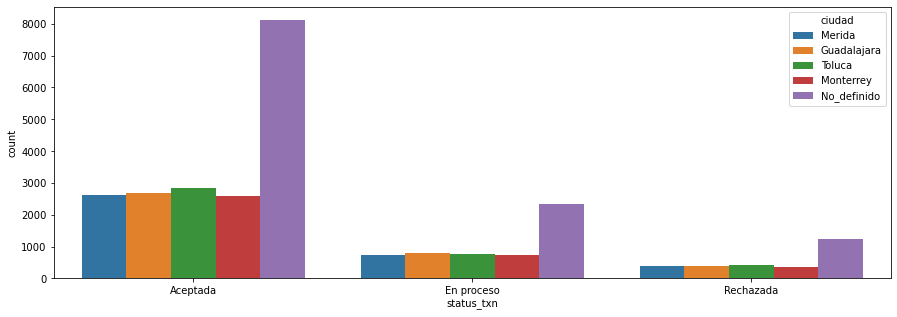

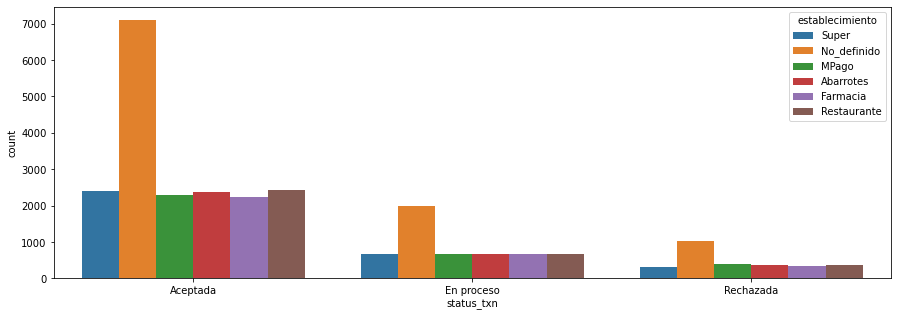

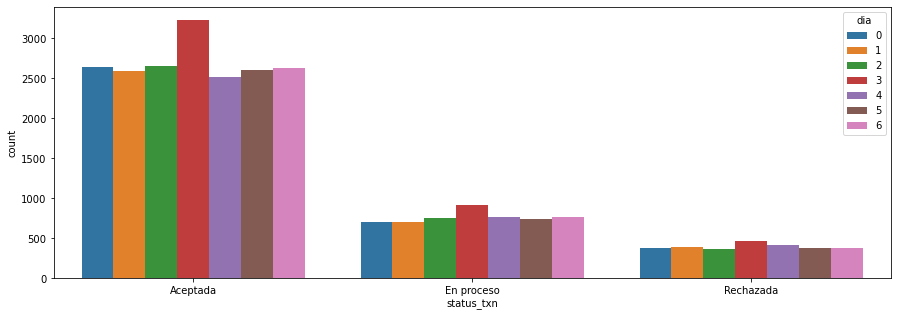

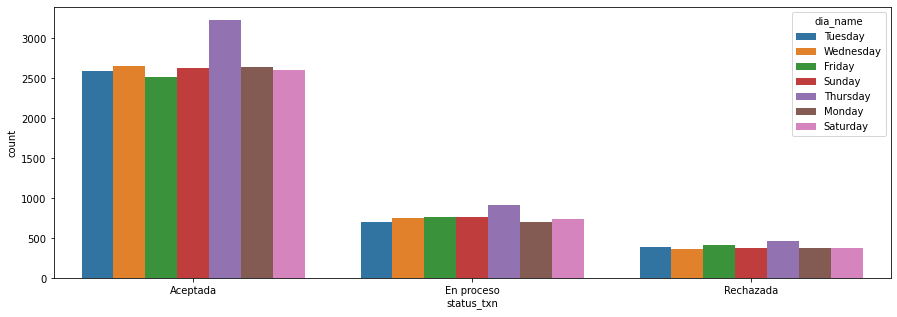

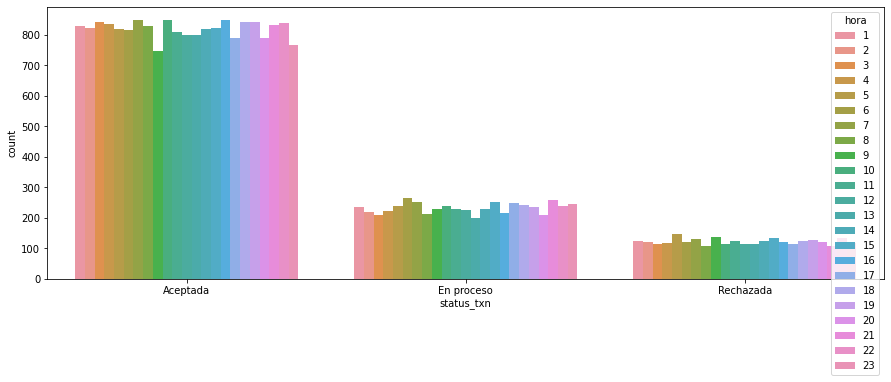

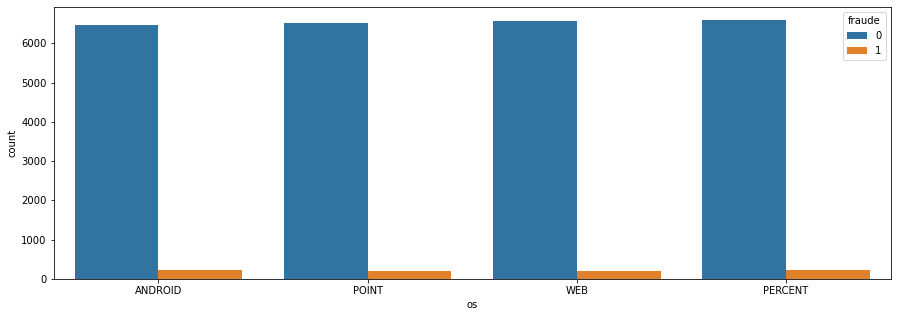

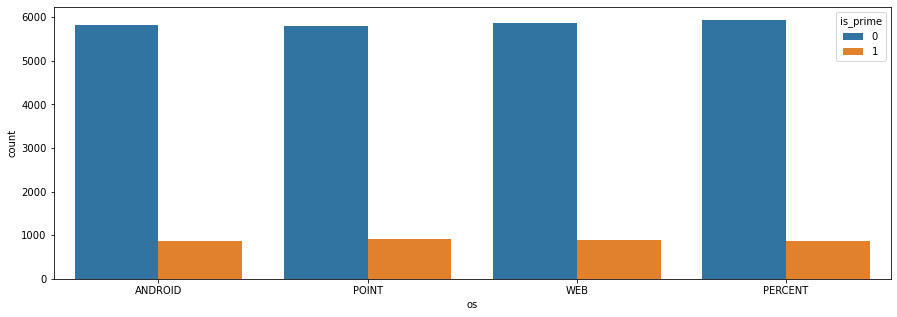

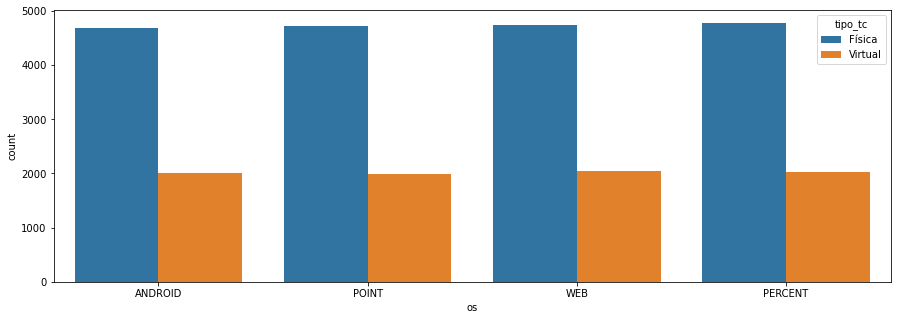

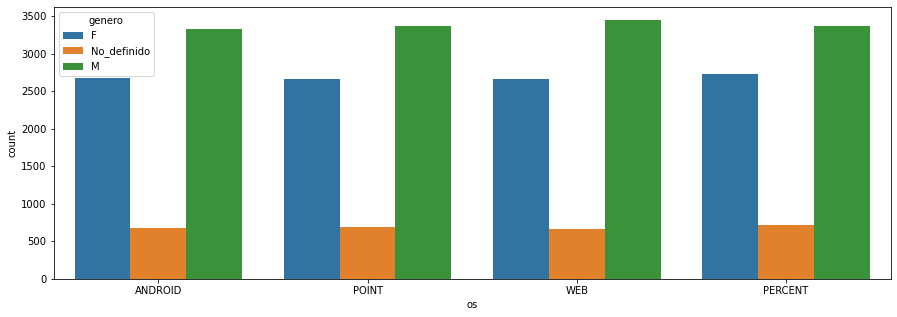

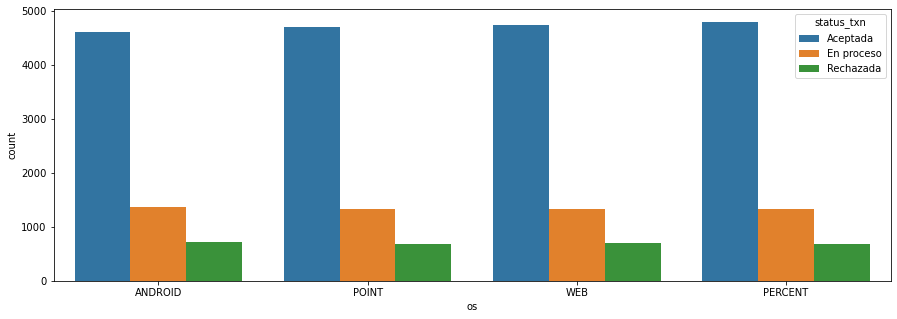

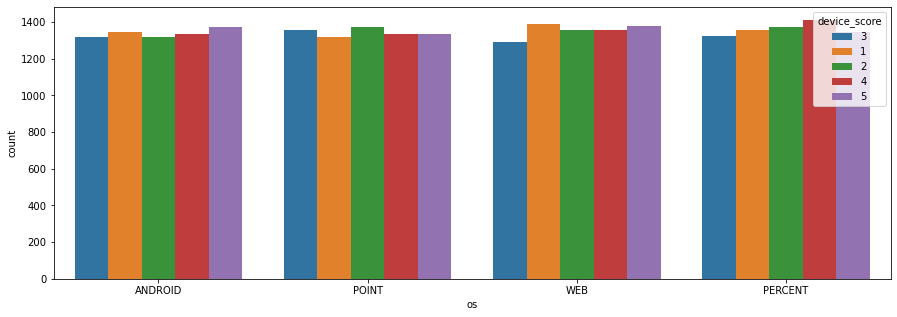

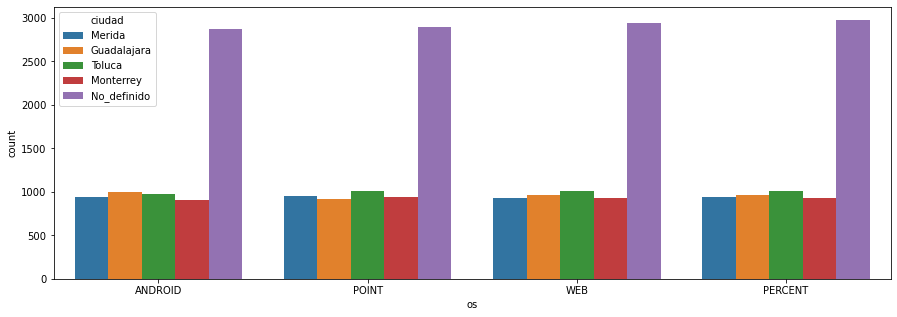

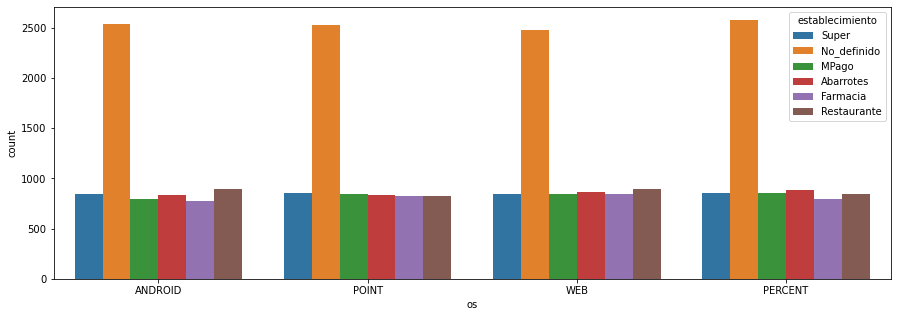

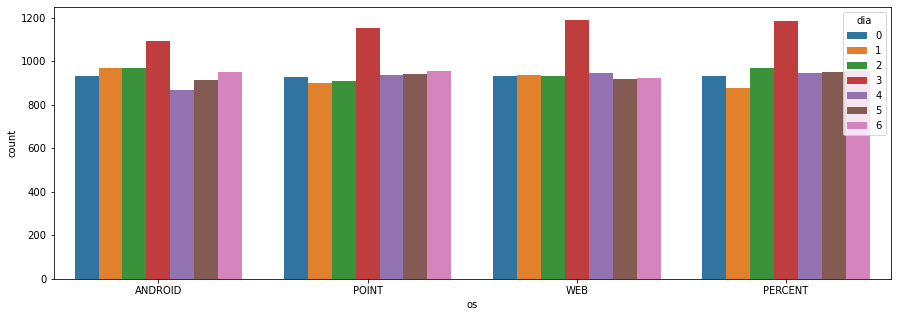

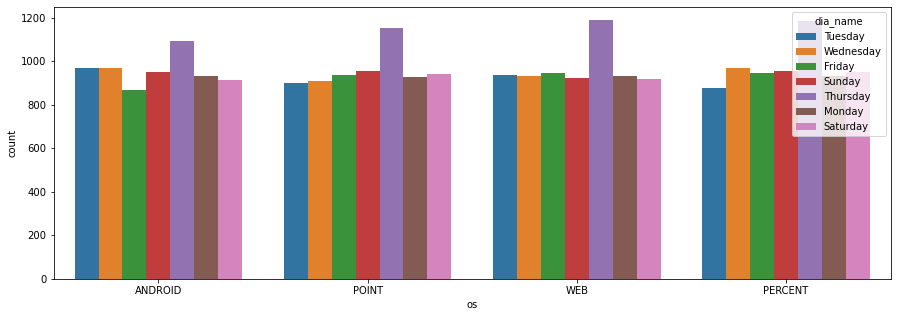

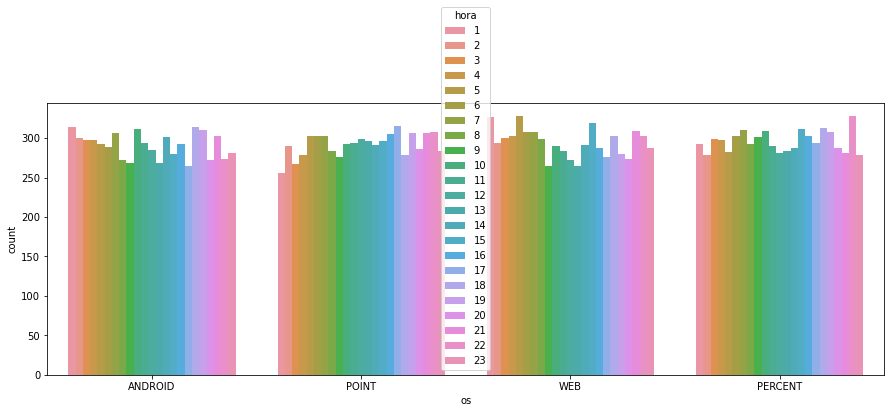

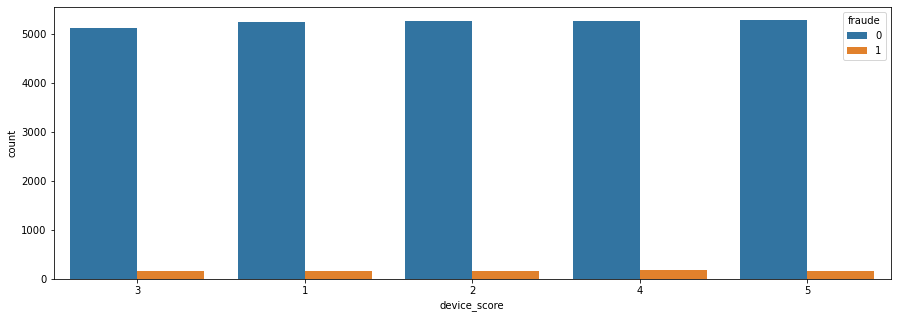

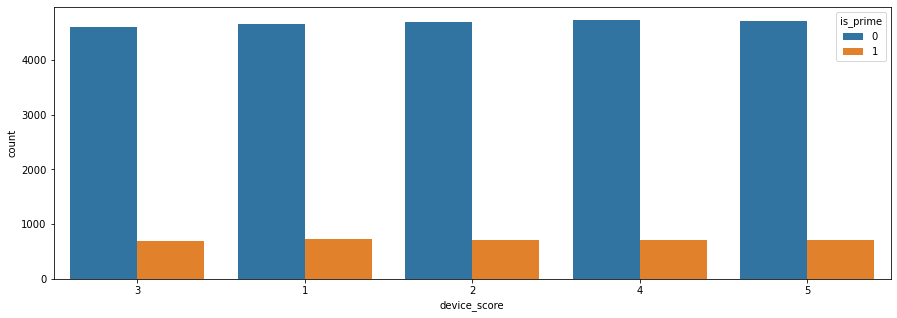

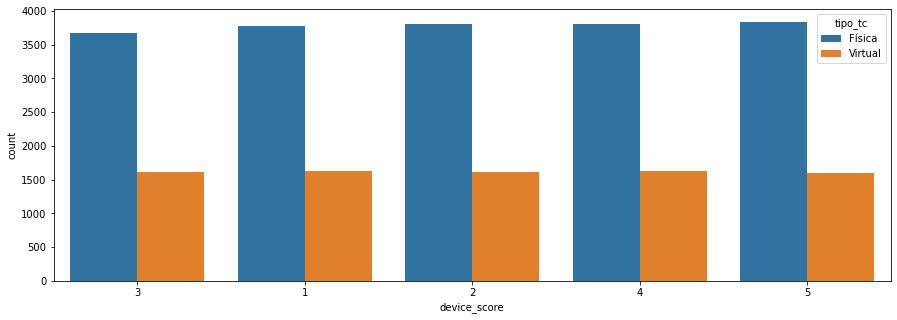

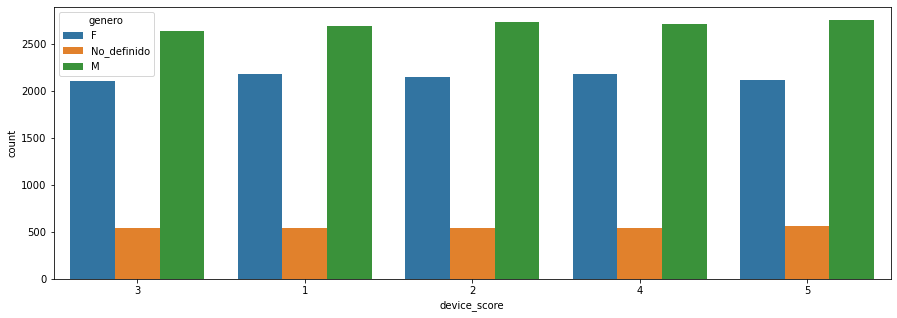

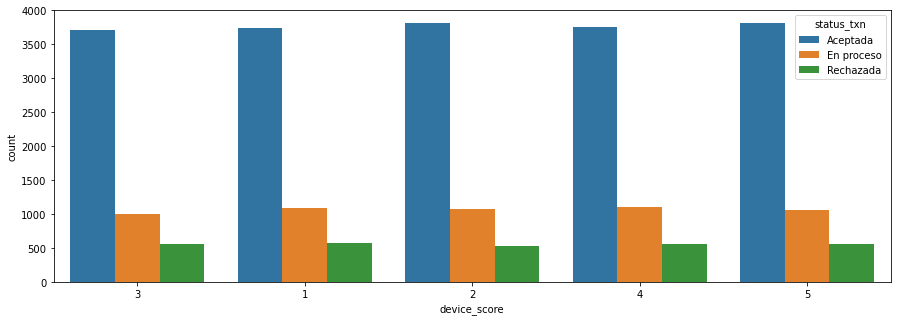

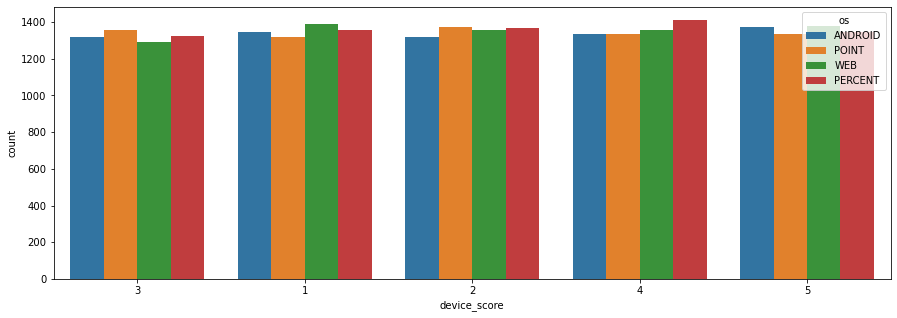

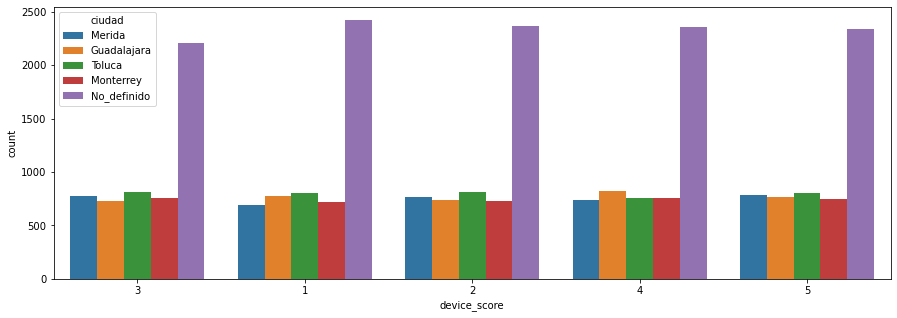

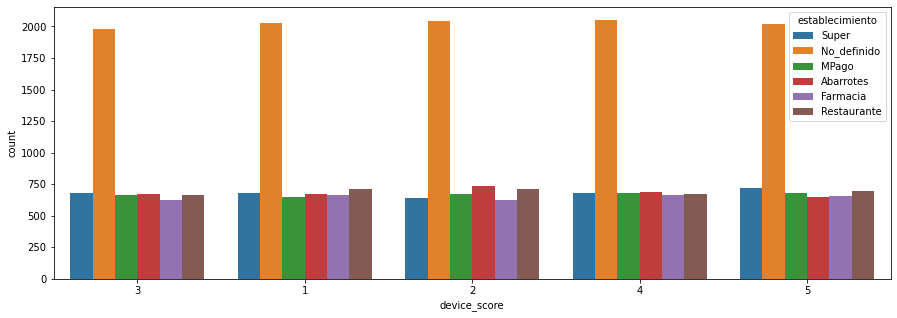

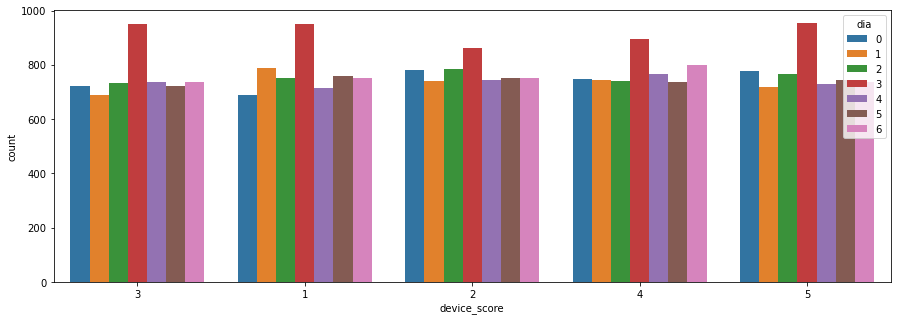

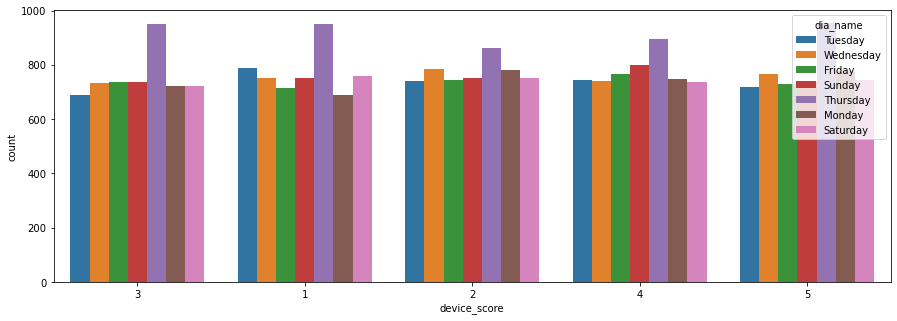

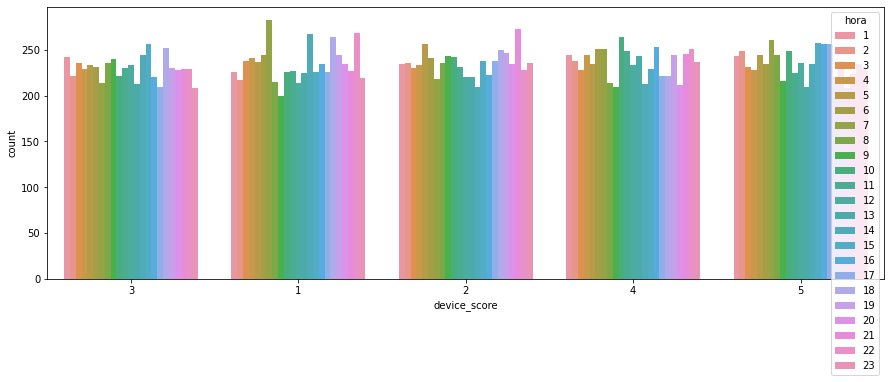

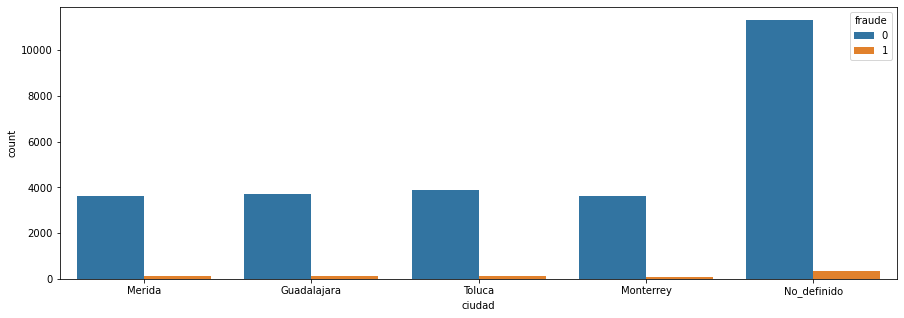

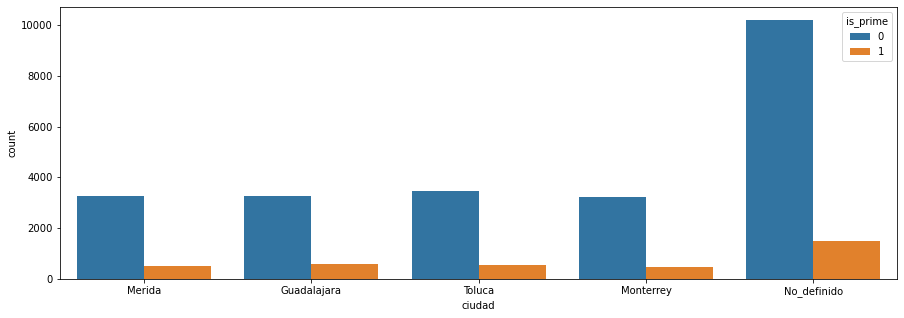

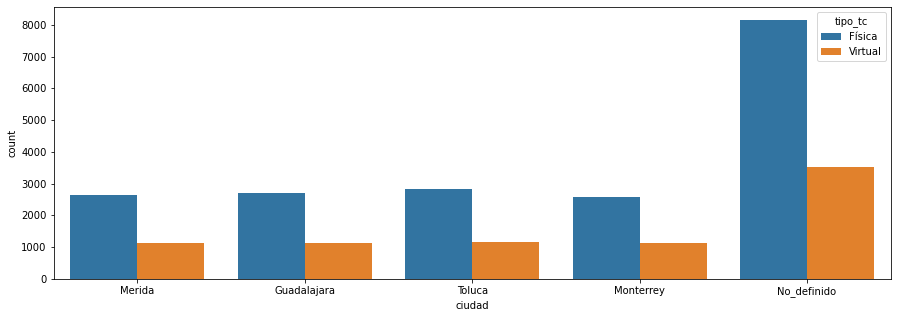

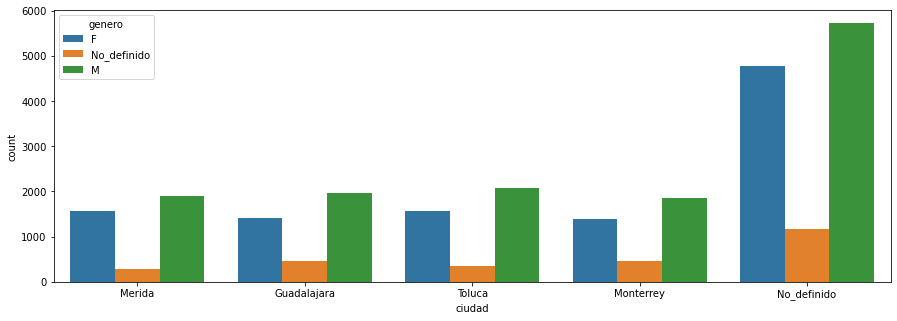

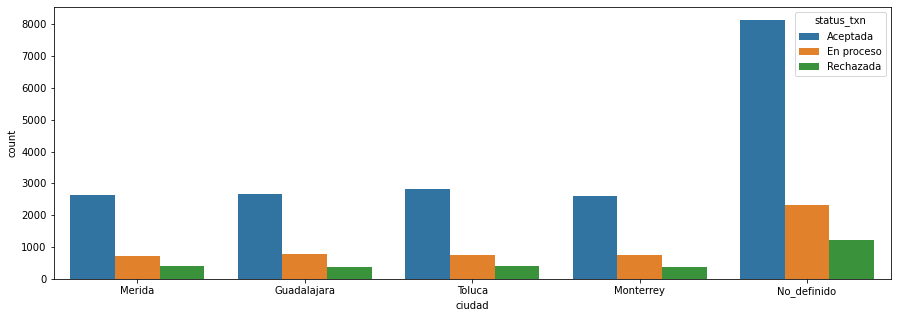

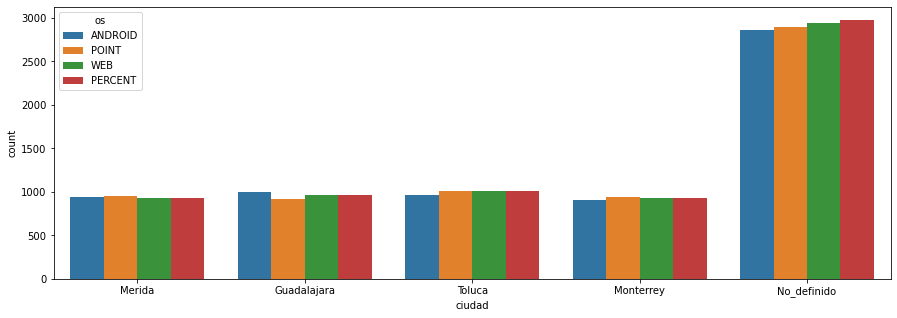

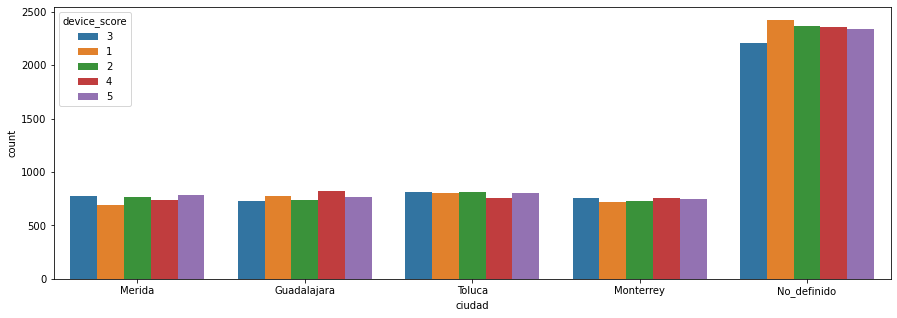

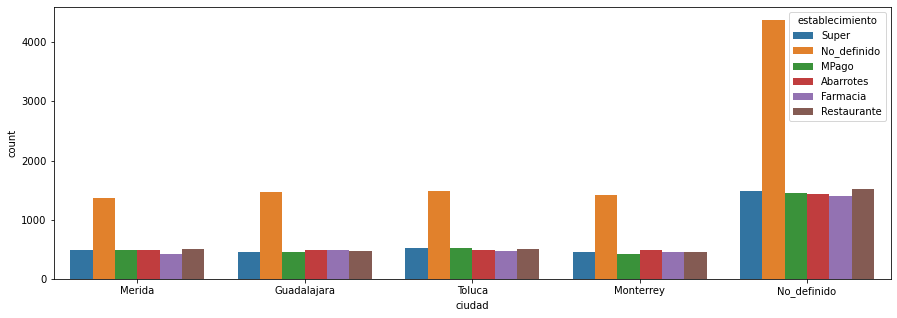

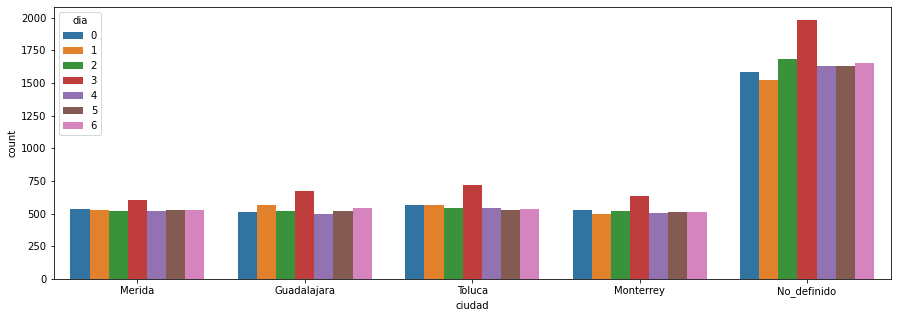

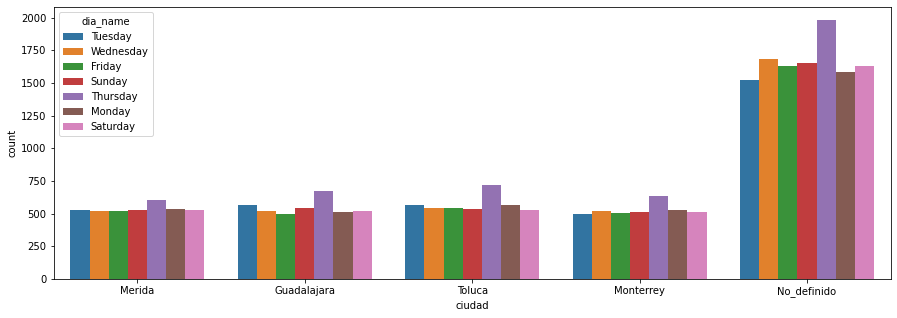

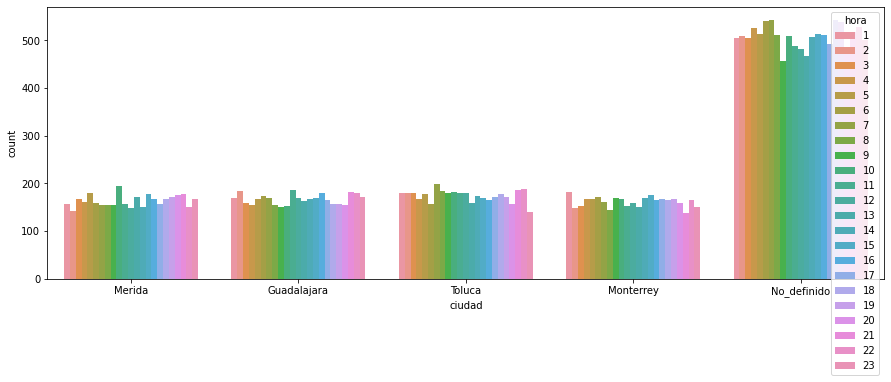

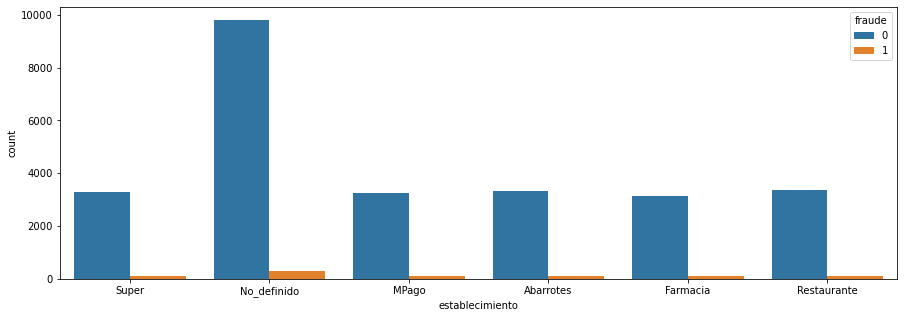

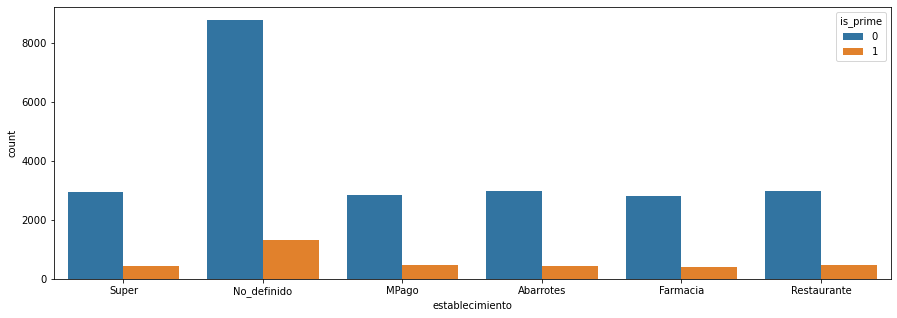

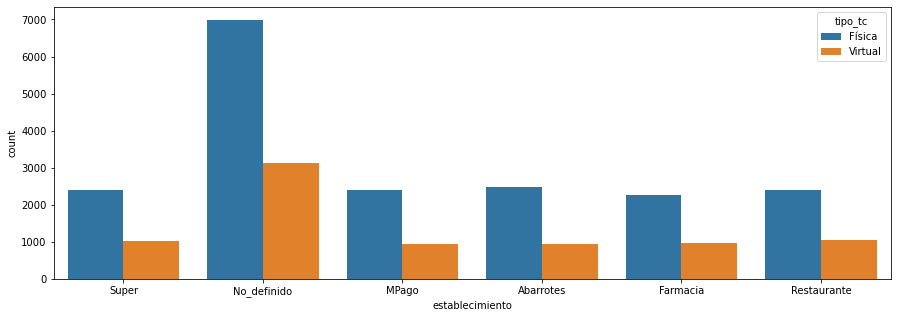

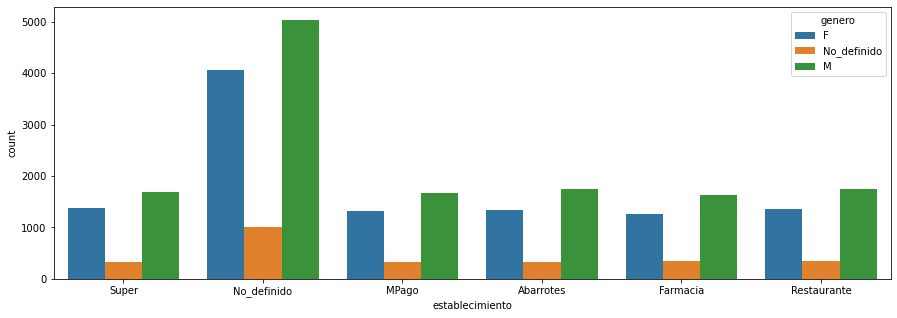

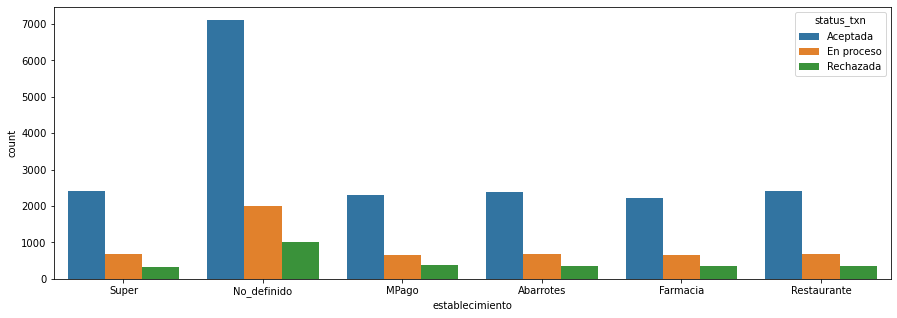

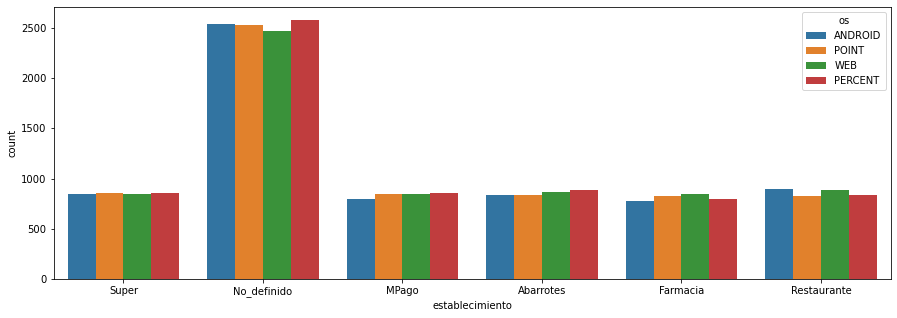

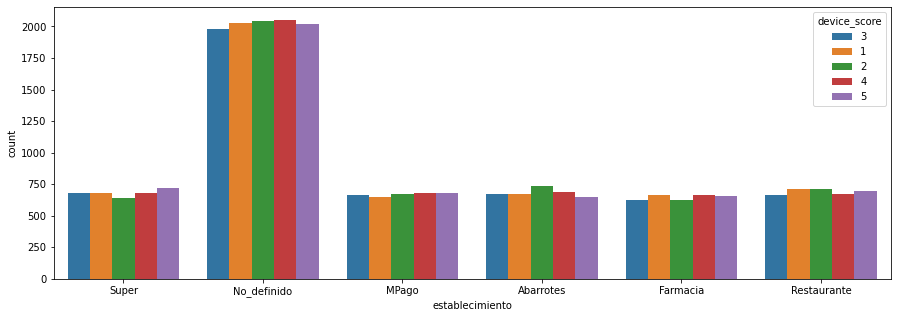

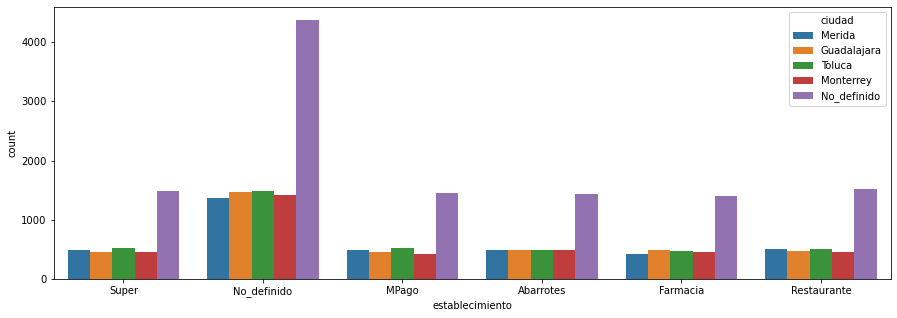

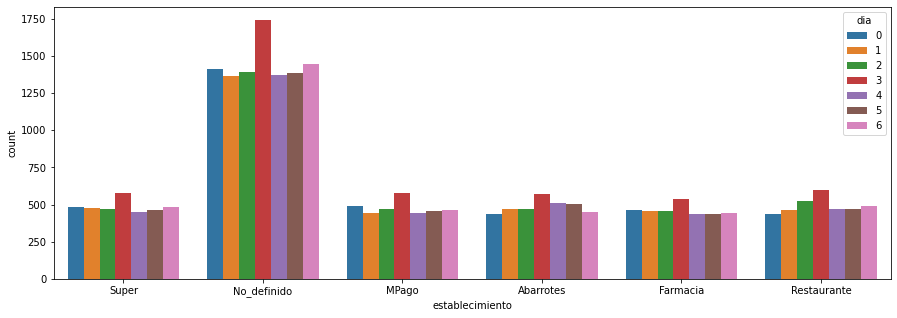

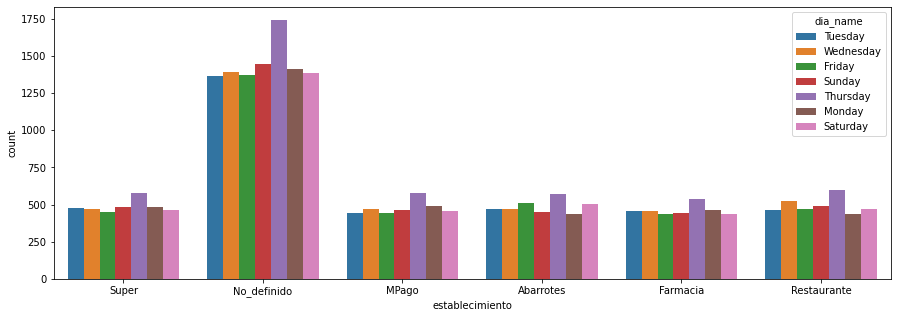

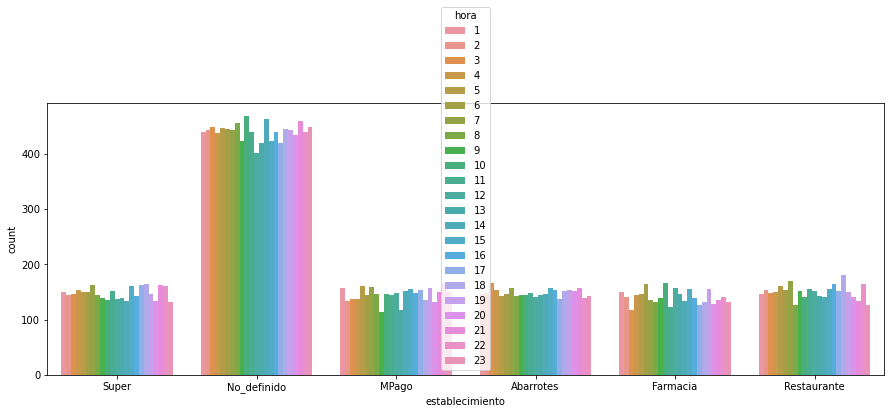

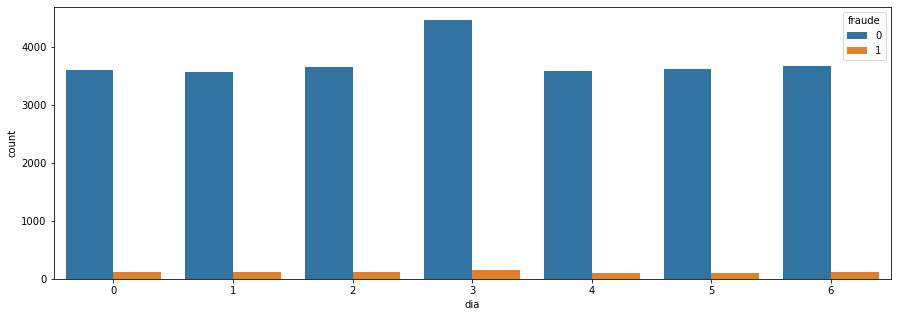

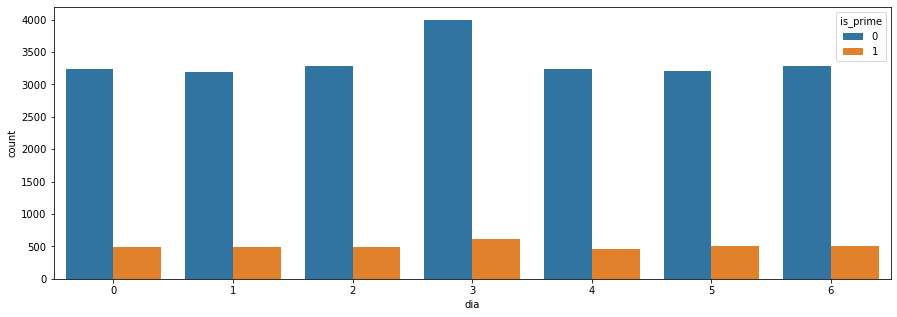

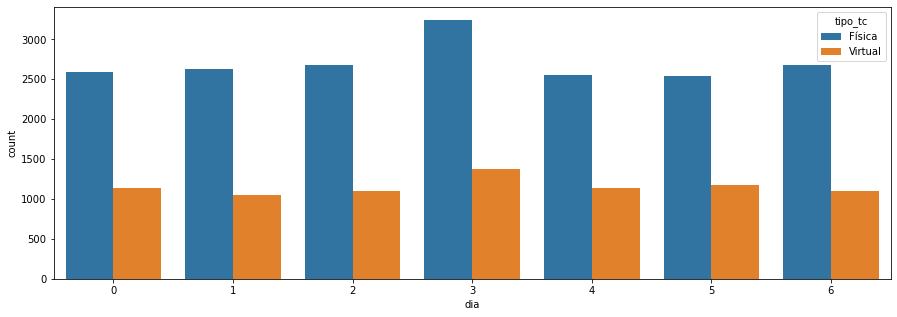

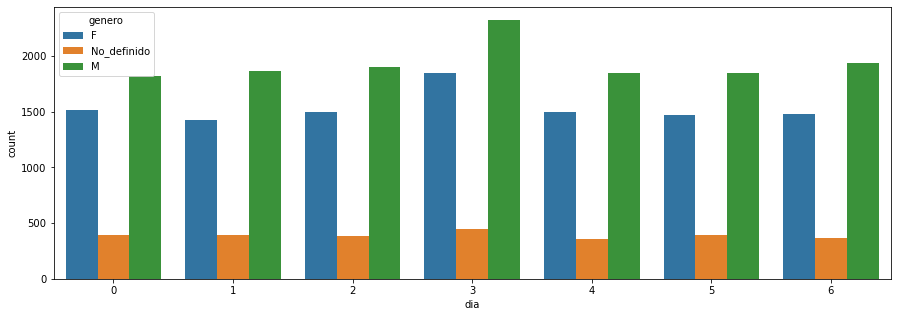

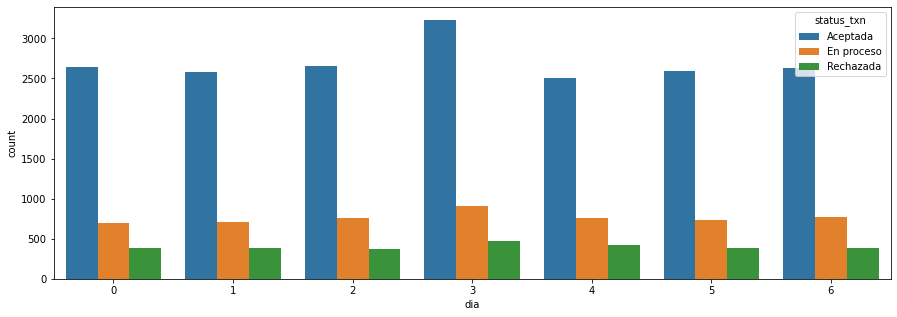

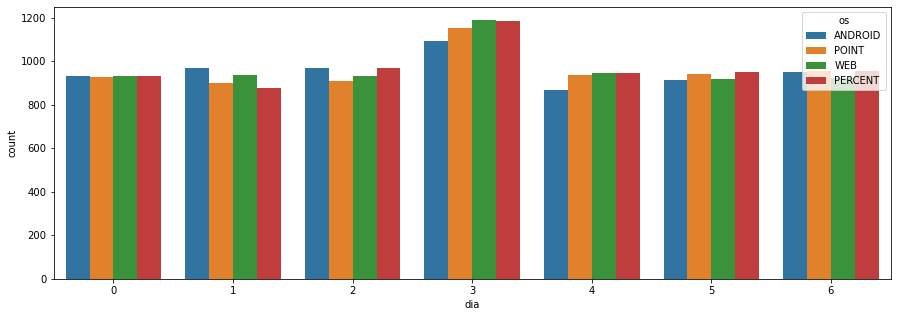

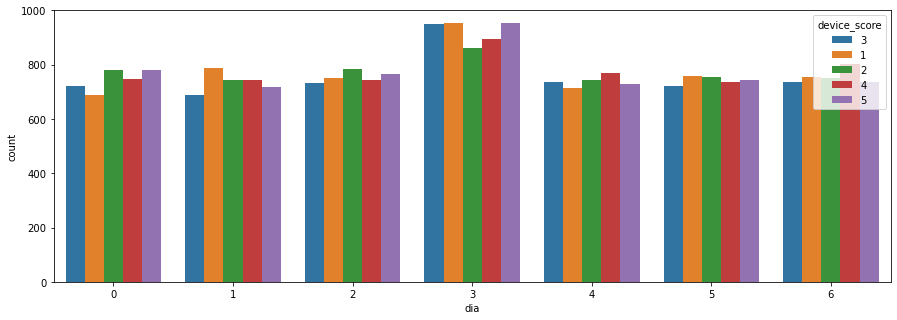

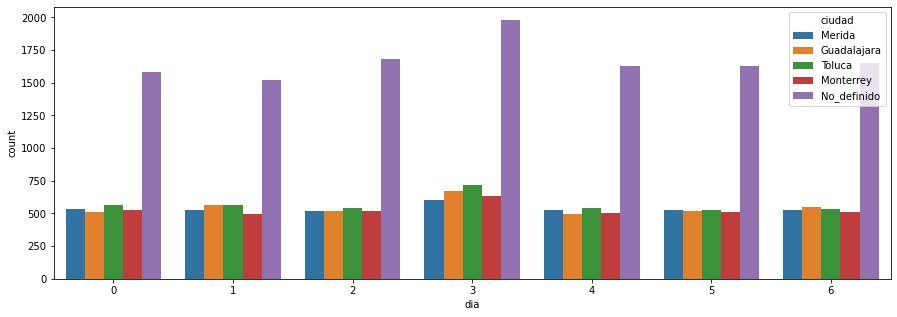

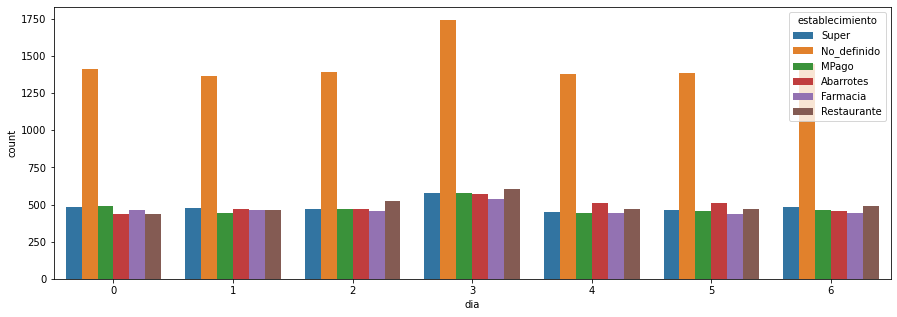

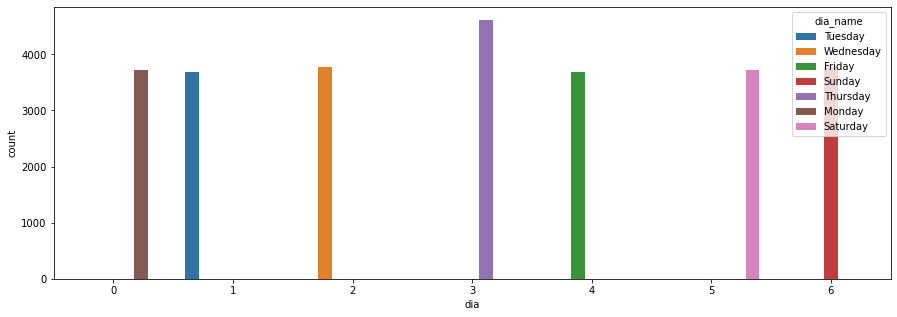

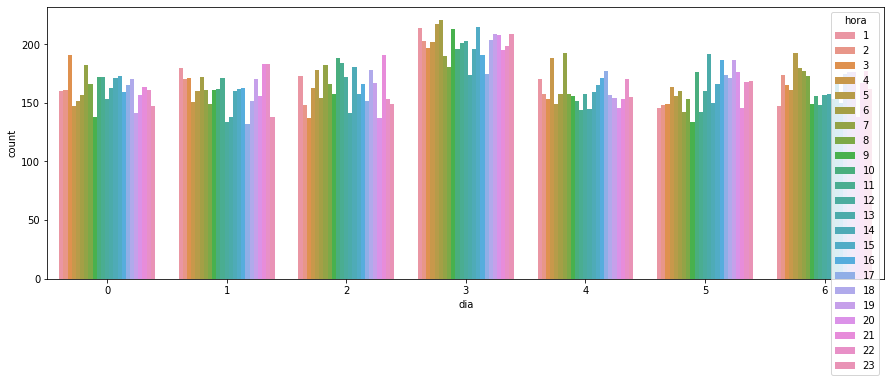

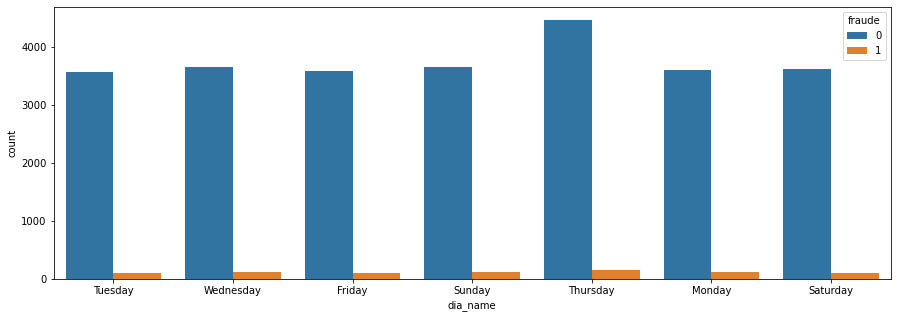

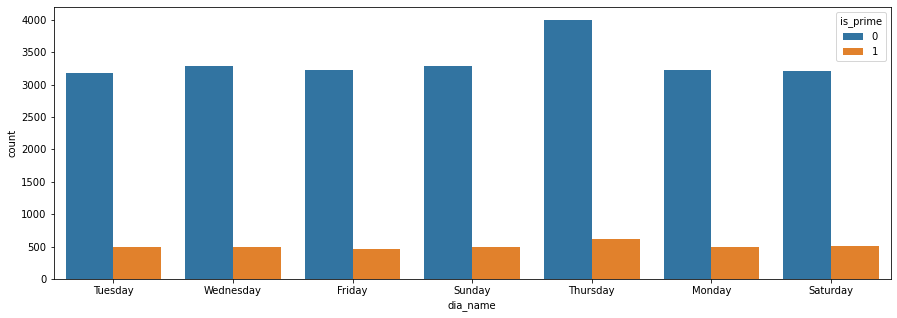

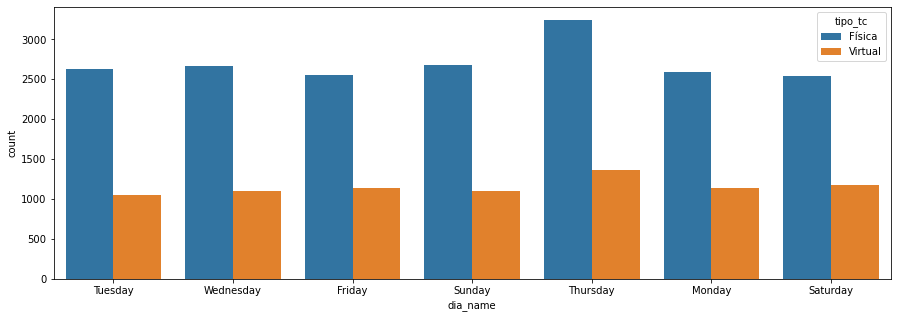

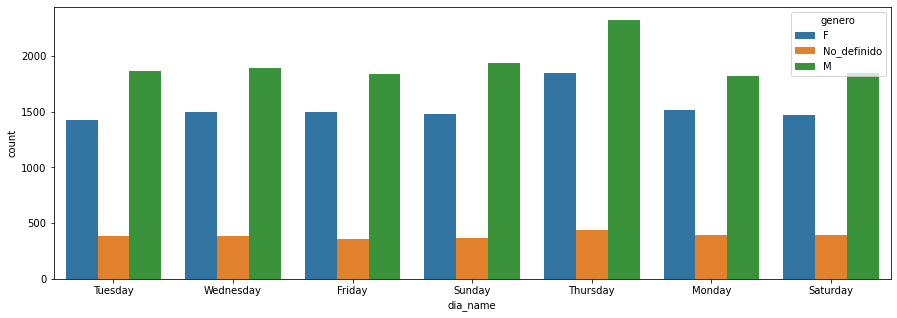

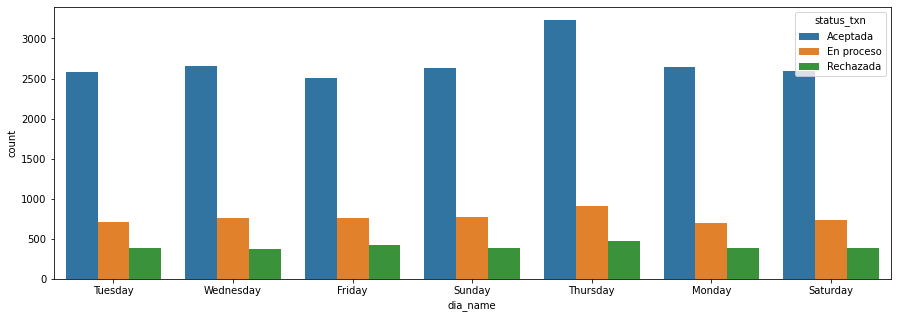

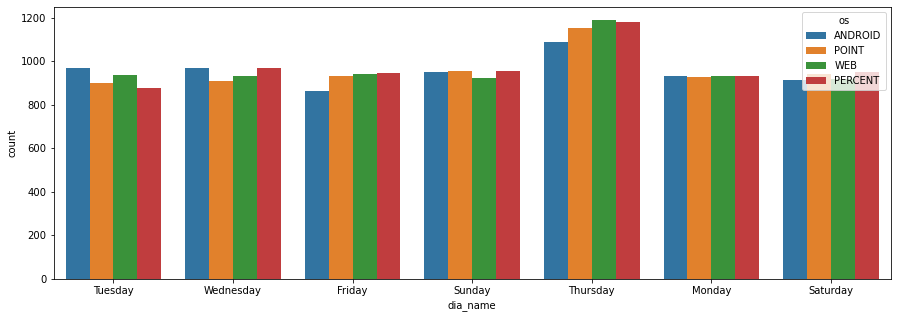

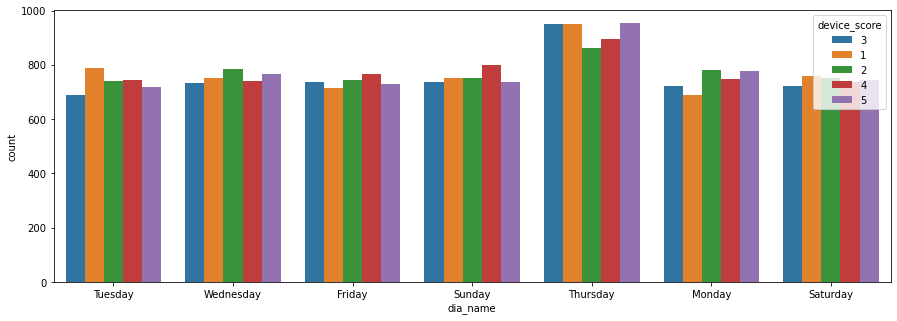

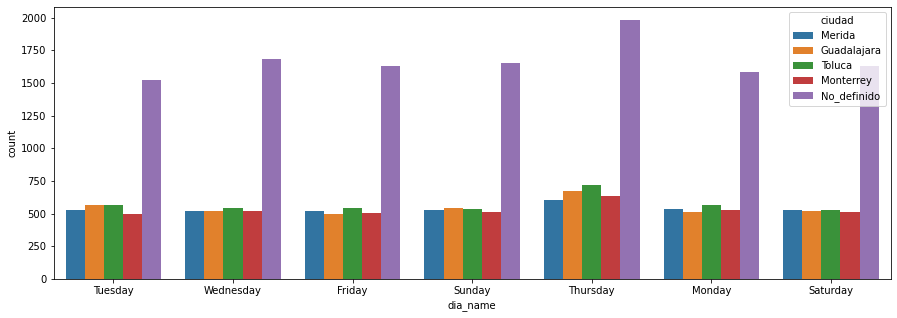

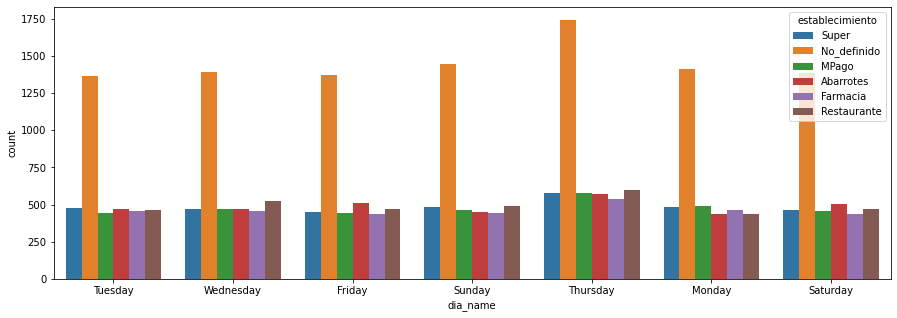

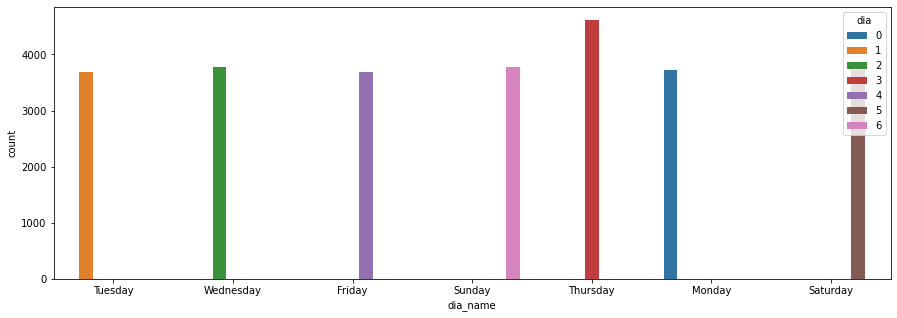

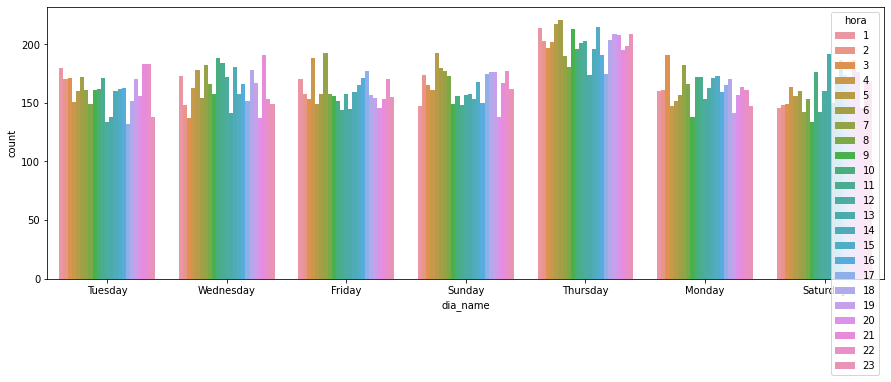

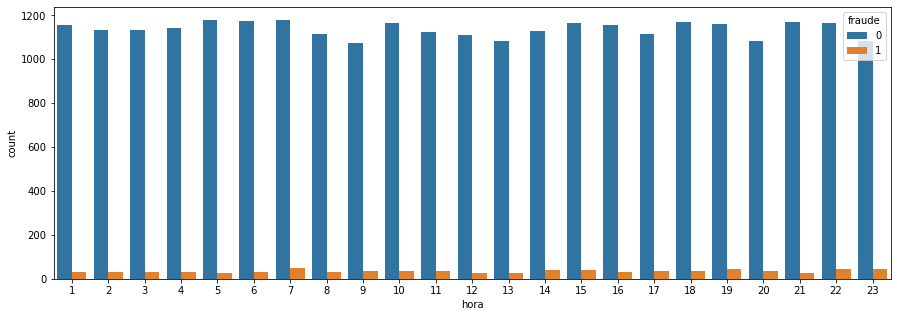

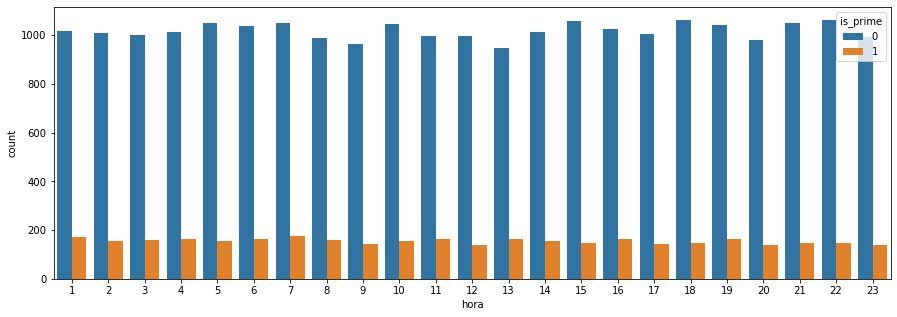

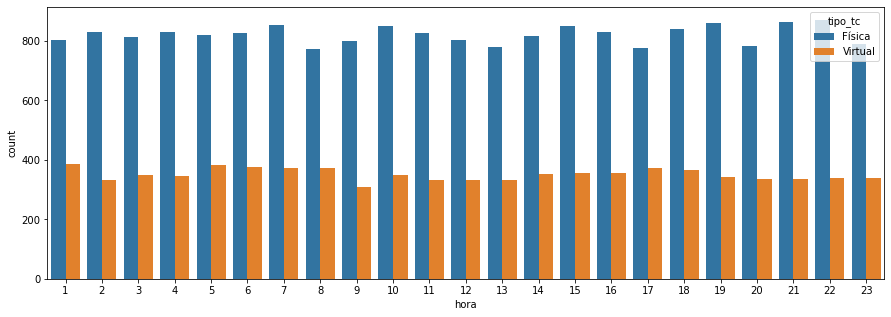

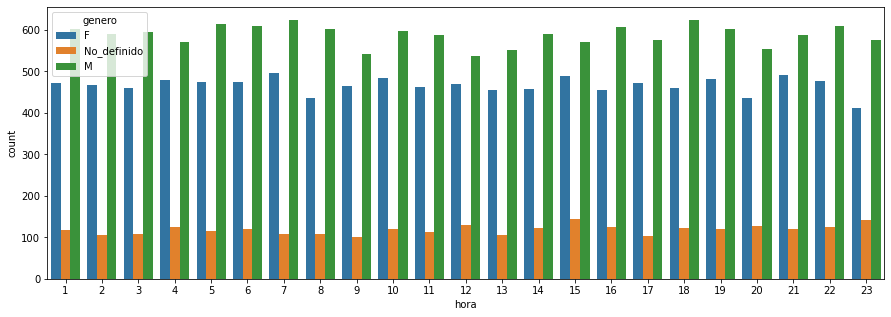

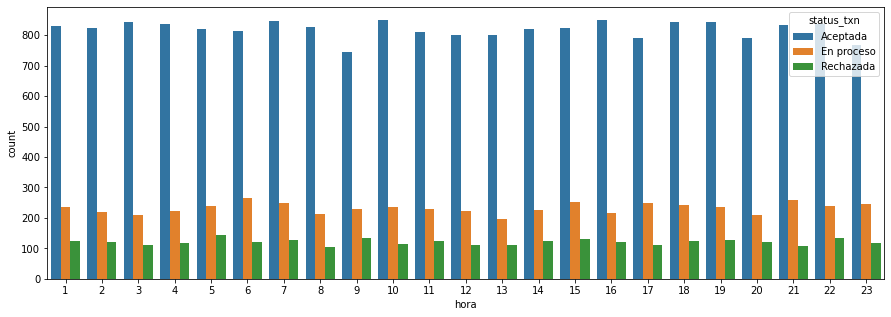

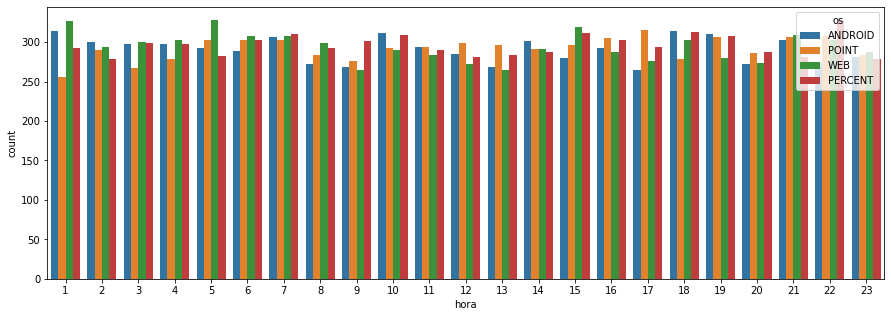

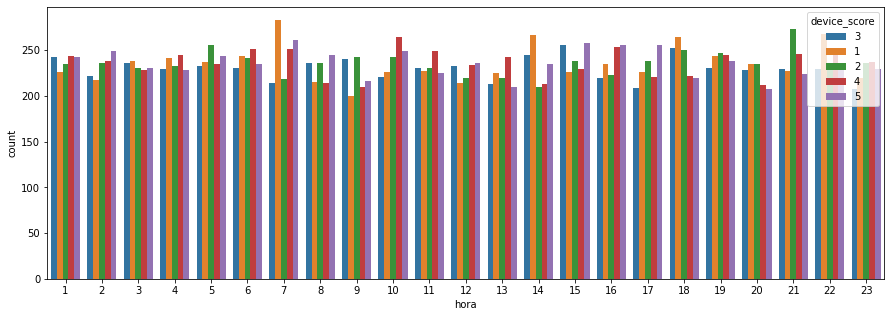

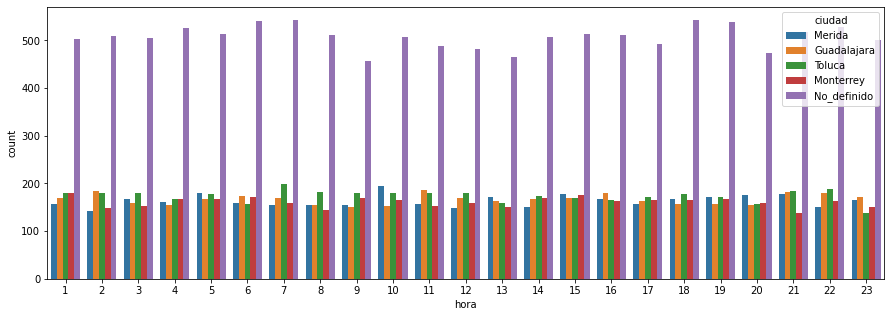

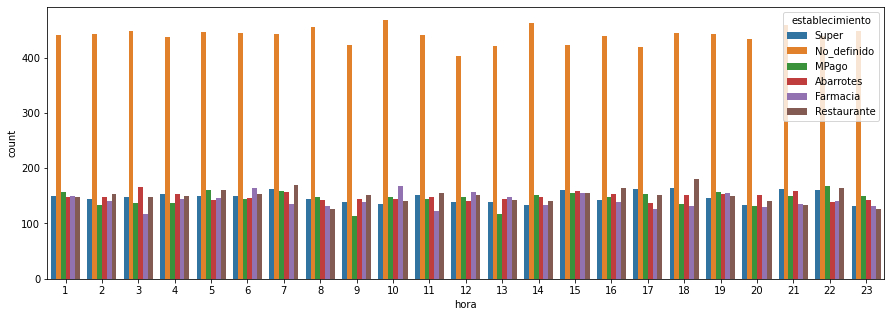

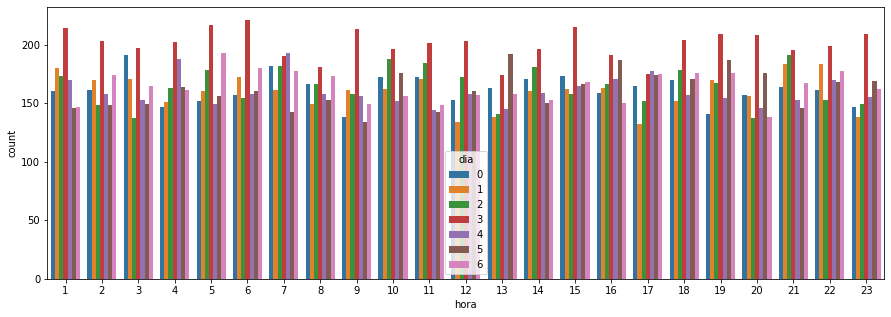

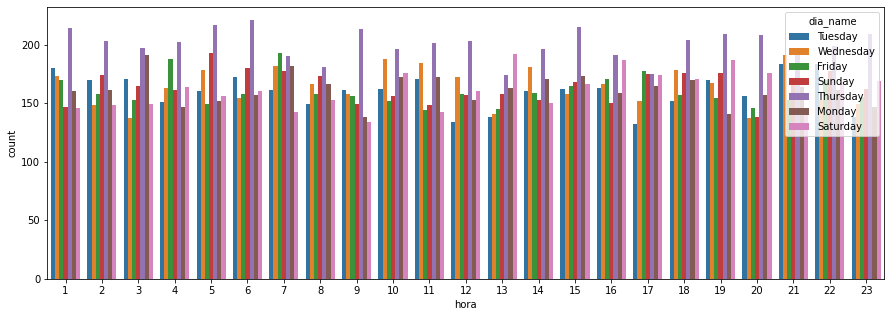

In [24]:
#ax = sns.countplot(x="class", hue="who", data=titanic)
for col in col_categoricos:
    for col2 in col_categoricos:
        if col!=col2:
            plt.subplots(figsize=(15, 5))
            sns.countplot(x=col,data=Data_raw, hue=col2)

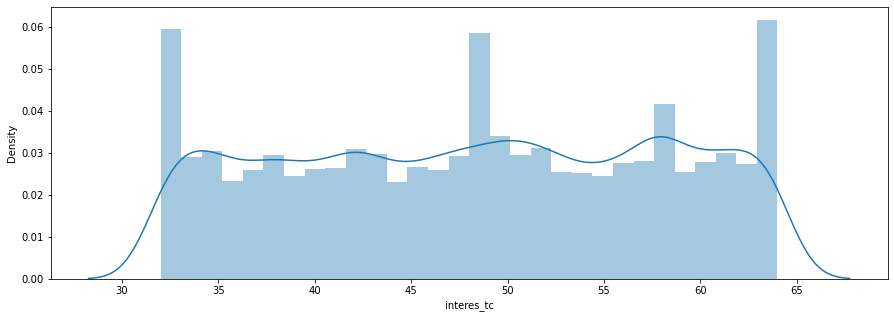

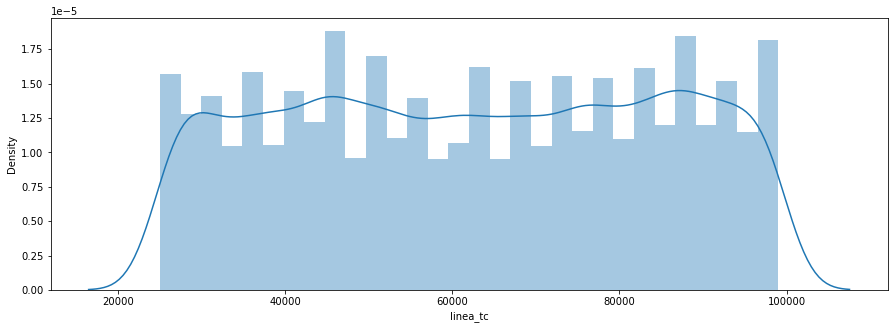

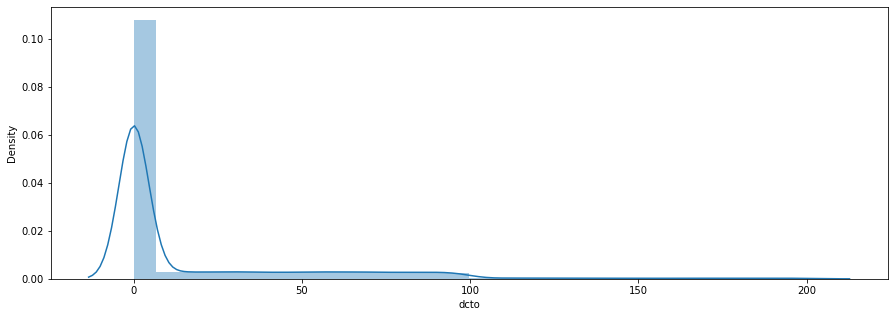

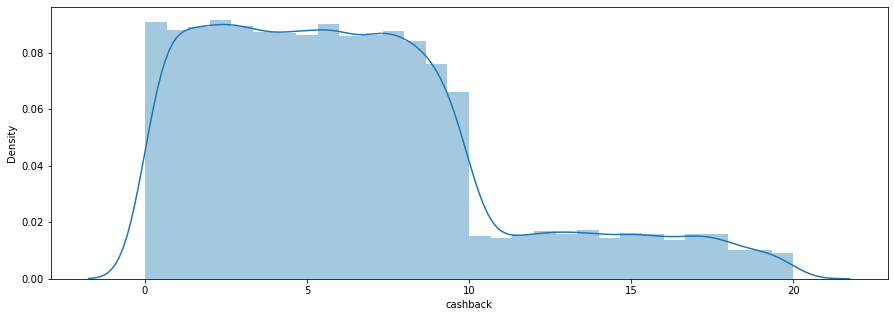

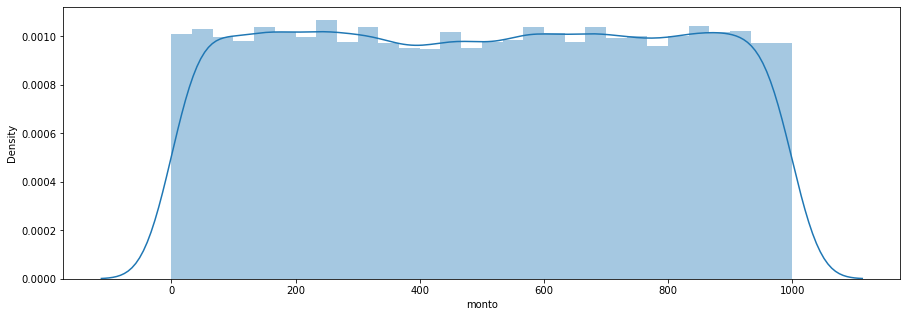

In [25]:
for col in col_num:
    plt.subplots(figsize=(15, 5))
    sns.distplot(Data_raw[col] ,kde=True,bins=30)

In [26]:
Data_raw[col_num].quantile([.05,.25,.5, .75, .87,.9, .95, .98, .99, .995, 1])

,interes_tc,linea_tc,dcto,cashback,monto
0.050,33.0,28000.0,0.000000,0.559756,49.527971
0.250,40.0,44000.0,0.000000,2.791740,246.521227
0.500,48.0,62000.0,0.000000,5.636711,500.501022
0.750,57.0,82000.0,18.770710,8.531604,749.598192
0.870,60.0,90000.0,61.417773,10.938886,869.133500
0.900,61.0,92000.0,71.989782,12.843523,898.403629
0.950,63.0,96000.0,90.412299,15.997217,948.983899
0.980,64.0,98000.0,117.897096,17.963631,979.558058
0.990,64.0,99000.0,159.106606,18.924224,989.343452
0.995,64.0,99000.0,180.502366,19.454001,994.224787


In [27]:
Data_raw['monto_cat'] = "CTE"
Data_raw['monto_cat'] = np.where( Data_raw['monto']<=245, "A_<245]" , Data_raw['monto_cat'] )
Data_raw['monto_cat'] = np.where( (Data_raw['monto']>245)&(Data_raw['monto']<=500), "B_<245-500]" , Data_raw['monto_cat'] )
Data_raw['monto_cat'] = np.where( (Data_raw['monto']>500)&(Data_raw['monto']<=750), "C_<500-750]" , Data_raw['monto_cat'] )
Data_raw['monto_cat'] = np.where( (Data_raw['monto']>750), "D_<+750>" , Data_raw['monto_cat'] )
Data_raw.drop(['monto'], axis=1, inplace=True)
print(Data_raw['monto_cat'].value_counts(dropna=False))

B_<245-500]    6774
C_<500-750]    6773
D_<+750>       6730
A_<245]        6698
Name: monto_cat, dtype: int64


In [28]:
Data_raw['cashback_cat'] = "CTE"
Data_raw['cashback_cat'] = np.where( Data_raw['cashback']<=2.5, "A_<2.5]" , Data_raw['cashback_cat'] )
Data_raw['cashback_cat'] = np.where( (Data_raw['cashback']>2.5)&(Data_raw['cashback']<=5.6), "B_<2.5-5.6]" , Data_raw['cashback_cat'] )
Data_raw['cashback_cat'] = np.where( (Data_raw['cashback']>5.6)&(Data_raw['cashback']<=8.5), "C_<5.6-8.5]" , Data_raw['cashback_cat'] )
Data_raw['cashback_cat'] = np.where( (Data_raw['cashback']>8.5), "D_<+8.5>" , Data_raw['cashback_cat'] )
Data_raw.drop(['cashback'], axis=1, inplace=True)
print(Data_raw['cashback_cat'].value_counts(dropna=False))

B_<2.5-5.6]    7357
D_<+8.5>       6819
C_<5.6-8.5]    6767
A_<2.5]        6032
Name: cashback_cat, dtype: int64


In [29]:
Data_raw['dcto_cat'] = "CTE"
Data_raw['dcto_cat'] = np.where( Data_raw['dcto']<=10, "A_<10]" , Data_raw['dcto_cat'] )
Data_raw['dcto_cat'] = np.where( (Data_raw['dcto']>10)&(Data_raw['dcto']<=60), "B_<10-60]" , Data_raw['dcto_cat'] )
Data_raw['dcto_cat'] = np.where( (Data_raw['dcto']>60), "C_<+60>" , Data_raw['dcto_cat'] )
Data_raw.drop(['dcto'], axis=1, inplace=True)
print(Data_raw['dcto_cat'].value_counts(dropna=False))

A_<10]       19565
B_<10-60]     3796
C_<+60>       3614
Name: dcto_cat, dtype: int64


In [30]:
Data_raw['linea_tc_cat'] = "CTE"
Data_raw['linea_tc_cat'] = np.where( Data_raw['linea_tc']<=44000, "A_<44000]" , Data_raw['linea_tc_cat'] )
Data_raw['linea_tc_cat'] = np.where( (Data_raw['linea_tc']>44000)&(Data_raw['linea_tc']<=62000), "B_<44000-62000]" , Data_raw['linea_tc_cat'] )
Data_raw['linea_tc_cat'] = np.where( (Data_raw['linea_tc']>62000)&(Data_raw['linea_tc']<=82000), "C_<62000-82000]" , Data_raw['linea_tc_cat'] )
Data_raw['linea_tc_cat'] = np.where( (Data_raw['linea_tc']>82000), "D_<+82000>" , Data_raw['linea_tc_cat'] )
Data_raw.drop(['linea_tc'], axis=1, inplace=True)
print(Data_raw['linea_tc_cat'].value_counts(dropna=False))

A_<44000]          7064
C_<62000-82000]    6994
D_<+82000>         6490
B_<44000-62000]    6427
Name: linea_tc_cat, dtype: int64


In [31]:
Data_raw['interes_tc_cat'] = "CTE"
Data_raw['interes_tc_cat'] = np.where( Data_raw['interes_tc']<=40, "A_<40]" , Data_raw['interes_tc_cat'] )
Data_raw['interes_tc_cat'] = np.where( (Data_raw['interes_tc']>40)&(Data_raw['interes_tc']<=50), "B_<40-50]" , Data_raw['interes_tc_cat'] )
Data_raw['interes_tc_cat'] = np.where( (Data_raw['interes_tc']>50)&(Data_raw['interes_tc']<=60), "C_<50-60]" , Data_raw['interes_tc_cat'] )
Data_raw['interes_tc_cat'] = np.where( (Data_raw['interes_tc']>60), "D_<+61>" , Data_raw['interes_tc_cat'] )
Data_raw.drop(['interes_tc'], axis=1, inplace=True)
print(Data_raw['interes_tc_cat'].value_counts(dropna=False))

C_<50-60]    8249
B_<40-50]    8171
A_<40]       7135
D_<+61>      3420
Name: interes_tc_cat, dtype: int64


In [32]:
aux_unique = var_unicos(Data_raw)
col_categoricos = aux_unique[aux_unique['Unicos']<30]['index'].tolist()
col_num = aux_unique[aux_unique['Unicos']>=30]['index'].tolist()
print(len(col_categoricos),"->",col_categoricos)
print(len(col_num),"->",col_num)
print(len(Data_raw.columns.tolist()))

17 -> ['tipo_tc', 'is_prime', 'fraude', 'genero', 'dcto_cat', 'status_txn', 'cashback_cat', 'monto_cat', 'os', 'interes_tc_cat', 'linea_tc_cat', 'ciudad', 'device_score', 'establecimiento', 'dia', 'dia_name', 'hora']
0 -> []
17


In [33]:
aux = var_unicos(Data_raw[col_categoricos])
print(aux[aux['Tipo']=="object"]['index'].tolist())

['tipo_tc', 'genero', 'dcto_cat', 'status_txn', 'linea_tc_cat', 'interes_tc_cat', 'os', 'monto_cat', 'cashback_cat', 'ciudad', 'device_score', 'establecimiento', 'dia_name']


In [34]:
#col_to_dummy = ['tipo_tc', 'genero', 'status_txn', 'os', 'device_score', 'ciudad', 'establecimiento', 'dia_name']
col_to_dummy = ['tipo_tc', 'genero', 'dcto_cat', 'status_txn', 'linea_tc_cat', 'interes_tc_cat', 'os', 'monto_cat', 'cashback_cat', 'ciudad', 'device_score', 'establecimiento', 'dia_name']

In [35]:
for col in col_to_dummy:
    Data_raw = crear_dummies(Data_raw, col )

In [36]:
Data_raw.dtypes

hora                            int64
is_prime                        int32
fraude                          int32
dia                             int64
tipo_tc_Física                  uint8
tipo_tc_Virtual                 uint8
genero_F                        uint8
genero_M                        uint8
genero_No_definido              uint8
dcto_cat_A_<10]                 uint8
dcto_cat_B_<10-60]              uint8
dcto_cat_C_<+60>                uint8
status_txn_Aceptada             uint8
status_txn_En proceso           uint8
status_txn_Rechazada            uint8
linea_tc_cat_A_<44000]          uint8
linea_tc_cat_B_<44000-62000]    uint8
linea_tc_cat_C_<62000-82000]    uint8
linea_tc_cat_D_<+82000>         uint8
interes_tc_cat_A_<40]           uint8
interes_tc_cat_B_<40-50]        uint8
interes_tc_cat_C_<50-60]        uint8
interes_tc_cat_D_<+61>          uint8
os_ANDROID                      uint8
os_PERCENT                      uint8
os_POINT                        uint8
os_WEB      

In [38]:
#df = Data_raw[col_num+['fraude']].corr()
#df = Data_raw.corr()
#sns.heatmap(df, cmap = "Blues", annot=True, square=True, fmt='.2f')

In [39]:
corr_detail(Data_raw, target)[:7]

,index,fraude,Abs
2,fraude,1.000000,1.000000
17,linea_tc_cat_C_<62000-82000],-0.015373,0.015373
0,hora,0.013376,0.013376
43,device_score_4,0.010722,0.010722
19,interes_tc_cat_A_<40],0.010220,0.010220
16,linea_tc_cat_B_<44000-62000],0.010203,0.010203
28,monto_cat_B_<245-500],0.008812,0.008812


In [40]:
corr_top(Data_raw, target, 7)

['linea_tc_cat_C_<62000-82000]',
 'hora',
 'device_score_4',
 'interes_tc_cat_A_<40]',
 'linea_tc_cat_B_<44000-62000]',
 'monto_cat_B_<245-500]',
 'interes_tc_cat_B_<40-50]']

# Modeling

In [41]:
target = 'fraude'
target

'fraude'

In [42]:
data_DF = Data_raw.copy()

## Split Data

In [43]:
from sklearn.model_selection import train_test_split
X_train, X_test = train_test_split(data_DF, test_size = 0.3, random_state = 101)

print(data_DF.shape)
print(X_train.shape)

(26975, 58)
(18882, 58)


In [44]:
print(X_train[target].value_counts(normalize=True))
print(X_test[target].value_counts(normalize=True))
print(X_train[target].value_counts())
print(X_test[target].value_counts())

0    0.969336
1    0.030664
Name: fraude, dtype: float64
0    0.971457
1    0.028543
Name: fraude, dtype: float64
0    18303
1      579
Name: fraude, dtype: int64
0    7862
1     231
Name: fraude, dtype: int64


## BALANCEO

In [45]:
# Conteo de las Clases
count_class_0,count_class_1 = X_train[target].value_counts()
# Dividimos las Clases
df_class_0 = X_train[X_train[target] == 0]
df_class_1 = X_train[X_train[target] == 1]

# Over Sampling
df_class_1_over = df_class_1.sample(count_class_0, replace=True)
df_balanceado_over = pd.concat([df_class_0, df_class_1_over], axis=0)
# Under Sampling
df_class_0_under = df_class_0.sample(count_class_1, replace=True)
df_balanceado_under = pd.concat([df_class_1, df_class_0_under], axis=0)

print('---> Random over-sampling:')
print(df_balanceado_over[target].value_counts())
print('---> Random under-sampling:')
print(df_balanceado_under[target].value_counts())

data_over = df_balanceado_over.copy()
data_under = df_balanceado_under.copy()
print("X_train shape:\t", X_train.shape)
print("data_over shape:\t", data_over.shape)
print("data_under shape:\t", data_under.shape)

---> Random over-sampling:
0    18303
1    18303
Name: fraude, dtype: int64
---> Random under-sampling:
0    579
1    579
Name: fraude, dtype: int64
X_train shape:	 (18882, 58)
data_over shape:	 (36606, 58)
data_under shape:	 (1158, 58)


## Select Drivers - Trees

In [46]:
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import cross_val_score

In [47]:
def get_drivers(dataframe, dataframe_y, top_variables):
    filter_col = dataframe.columns #selecionar features ###<<<<<<<<<<<<

    forest = RFC(n_jobs=2,n_estimators=200)
    forest.fit(dataframe[filter_col], dataframe_y[target])#<<<<< Target ya definido
    importances1 = forest.feature_importances_

    extree = ExtraTreesClassifier()
    extree.fit(dataframe[filter_col], dataframe_y[target])
    relval = extree.feature_importances_

    forest = ExtraTreesClassifier(n_estimators=200, random_state=0)
    forest.fit(dataframe[filter_col], dataframe_y[target])
    importances2 = forest.feature_importances_
    std = np.std([tree.feature_importances_ for tree in forest.estimators_],
                 axis=0)
    indices = np.argsort(importances2)[::-1]

    top_v = top_variables
    drivers1 = pd.DataFrame( {'IMP':importances1 ,'Driver':filter_col} 
                ).sort_values(by=["IMP"],ascending=False).head(top_v)['Driver'].tolist()
    drivers2 = pd.DataFrame( {'IMP':relval ,'Driver':filter_col} 
                ).sort_values(by=["IMP"],ascending=False).head(top_v)['Driver'].tolist()
    drivers3 = pd.DataFrame( {'IMP':importances2 ,'Driver':filter_col} 
                ).sort_values(by=["IMP"],ascending=False).head(top_v)['Driver'].tolist()

    drivers = drivers1+drivers2+drivers3 #+['GROUP_oper','GROUP_demog','GROUP_prod','GROUP_NM','GROUP_trxs'] 
    drivers = set(drivers)
    drivers = list(drivers)
    print(len(drivers))

    return drivers

In [48]:
print(X_train.shape)
#data_DF.sample(1)

(18882, 58)


In [49]:
#X_train.sample(2).T

In [50]:
X_train_ALL = X_train.iloc[:, ~X_train.columns.isin(["ITEM"]+[target])].copy()
y_train_ALL = X_train.iloc[:, X_train.columns == target].copy()

X_VAL = X_test.iloc[:, ~X_test.columns.isin(["ITEM"]+[target])].copy()
y_VAL = X_test.iloc[:, X_test.columns == target].copy()

print(X_train_ALL.shape)
print(X_VAL.shape)

(18882, 57)
(8093, 57)


In [51]:
drivers_ALL = get_drivers(X_train_ALL, y_train_ALL, 10)

12


In [52]:
drivers = drivers_ALL
print(drivers)

['establecimiento_No_definido', 'ciudad_No_definido', 'genero_M', 'linea_tc_cat_A_<44000]', 'hora', 'os_PERCENT', 'dia', 'interes_tc_cat_C_<50-60]', 'device_score_1', 'interes_tc_cat_A_<40]', 'genero_F', 'linea_tc_cat_D_<+82000>']


In [53]:
from sklearn.ensemble import RandomForestClassifier

In [54]:
rf = RandomForestClassifier()
rf.fit(X_train_ALL[drivers],  y_train_ALL[target].ravel() )
print(pd.DataFrame(rf.feature_importances_, index = drivers, columns=['importance']).sort_values('importance',ascending=False))

                             importance
hora                           0.434646
dia                            0.214323
ciudad_No_definido             0.048411
os_PERCENT                     0.040124
device_score_1                 0.039544
establecimiento_No_definido    0.038762
linea_tc_cat_A_<44000]         0.035865
interes_tc_cat_C_<50-60]       0.035793
interes_tc_cat_A_<40]          0.032733
linea_tc_cat_D_<+82000>        0.032185
genero_F                       0.024956
genero_M                       0.022657


In [55]:
rf_over = RandomForestClassifier()
rf_under = RandomForestClassifier()
rf_over_entropy = RandomForestClassifier(criterion="entropy")
rf_under_entropy = RandomForestClassifier(criterion="entropy")

rf_over.fit(data_over[drivers],  data_over[target].ravel() )
rf_under.fit(data_under[drivers],  data_under[target].ravel() )
rf_over_entropy.fit(data_over[drivers],  data_over[target].ravel() )
rf_under_entropy.fit(data_under[drivers],  data_under[target].ravel() )

RandomForestClassifier(criterion='entropy')

In [56]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()
lr_over = LogisticRegression()
lr_under = LogisticRegression()

lr.fit( X_train_ALL[drivers], y_train_ALL[target].ravel() )
lr_over.fit( data_over[drivers], data_over[target].ravel() )
lr_under.fit( data_under[drivers], data_under[target].ravel() )

LogisticRegression()

In [57]:
modelos = pd.concat([evaluar_rf( X_VAL[drivers], y_VAL, rf , "rf"),
evaluar_rf( X_VAL[drivers], y_VAL, rf_over, "rf_over"),
evaluar_rf( X_VAL[drivers], y_VAL, rf_under, "rf_under"),
evaluar_rf( X_VAL[drivers], y_VAL, rf_over_entropy, "rf_over_entropy" ),
evaluar_rf( X_VAL[drivers], y_VAL, rf_under_entropy, "rf_under_entropy" ),
                     
evaluar_rf( X_VAL[drivers], y_VAL, lr, "lr"),
evaluar_rf( X_VAL[drivers], y_VAL, lr_over, "lr_over"),
evaluar_rf( X_VAL[drivers], y_VAL, lr_under, "lr_under")], axis=0)

Modelo:  rf
Accuracy: 0.963 	Precision: 0.042 	Recall: 0.013 	F1: 0.020
[[7794   68]
 [ 228    3]]
Modelo:  rf_over
Accuracy: 0.946 	Precision: 0.041 	Recall: 0.039 	F1: 0.040
[[7649  213]
 [ 222    9]]
Modelo:  rf_under
Accuracy: 0.491 	Precision: 0.029 	Recall: 0.511 	F1: 0.054
[[3854 4008]
 [ 113  118]]
Modelo:  rf_over_entropy
Accuracy: 0.946 	Precision: 0.040 	Recall: 0.039 	F1: 0.039
[[7645  217]
 [ 222    9]]
Modelo:  rf_under_entropy
Accuracy: 0.495 	Precision: 0.027 	Recall: 0.485 	F1: 0.052
[[3893 3969]
 [ 119  112]]
Modelo:  lr
Accuracy: 0.971 	Precision: 0.000 	Recall: 0.000 	F1: 0.000
[[7862    0]
 [ 231    0]]
Modelo:  lr_over
Accuracy: 0.527 	Precision: 0.031 	Recall: 0.515 	F1: 0.059
[[4146 3716]
 [ 112  119]]
Modelo:  lr_under
Accuracy: 0.515 	Precision: 0.030 	Recall: 0.506 	F1: 0.056
[[4047 3815]
 [ 114  117]]


In [58]:
#modelos.sort_values(by=['F1'], ascending=[False])
#modelos.sort_values(by=['ROC_AUC'], ascending=[False])
modelos.sort_values(by=['Recall'], ascending=[False])

,modelo,Accuracy,Precision,Recall,F1,ROC_AUC,Gini
0,lr_over,0.526999,0.031030,0.515152,0.058534,0.521249,0.042498
0,rf_under,0.490795,0.028599,0.510823,0.054166,0.500514,0.001029
0,lr_under,0.514519,0.029756,0.506494,0.056209,0.510624,0.021248
0,rf_under_entropy,0.494872,0.027444,0.484848,0.051948,0.490008,-0.019985
0,rf_over,0.946250,0.040541,0.038961,0.039735,0.505934,0.011869
0,rf_over_entropy,0.945756,0.039823,0.038961,0.039387,0.505680,0.011360
0,rf,0.963425,0.042254,0.012987,0.019868,0.502169,0.004338
0,lr,0.971457,0.000000,0.000000,0.000000,0.500000,0.000000


In [59]:
print(pd.DataFrame(rf_under.feature_importances_, index = drivers, columns=['importance']).sort_values('importance',ascending=False))

                             importance
hora                           0.362459
dia                            0.209090
ciudad_No_definido             0.054315
establecimiento_No_definido    0.051557
os_PERCENT                     0.050746
linea_tc_cat_D_<+82000>        0.047069
linea_tc_cat_A_<44000]         0.044881
interes_tc_cat_C_<50-60]       0.043610
device_score_1                 0.038720
interes_tc_cat_A_<40]          0.036174
genero_F                       0.032677
genero_M                       0.028701


In [60]:
pd.DataFrame(rf_under.feature_importances_, index = drivers, columns=['importance']).sort_values('importance',ascending=False).index.tolist()

['hora',
 'dia',
 'ciudad_No_definido',
 'establecimiento_No_definido',
 'os_PERCENT',
 'linea_tc_cat_D_<+82000>',
 'linea_tc_cat_A_<44000]',
 'interes_tc_cat_C_<50-60]',
 'device_score_1',
 'interes_tc_cat_A_<40]',
 'genero_F',
 'genero_M']

In [1]:
from utilSD import per_missing, var_unicos, corr_top, corr_detail, crear_dummies, evaluar_rf
import pandas as pd
import numpy as np
import time
import datetime as dt

from sklearn.ensemble import RandomForestClassifier

Data_raw = pd.read_csv("..\data\ds_challenge_2021.csv", sep=",")

Data_raw['fraude'] = Data_raw['fraude'].astype(int)

dispositivo_json_cols = list(eval(Data_raw['dispositivo'].loc[0]).keys())
list_data = list(Data_raw['dispositivo'].apply( lambda x: list( map(lambda x:str(x),list(eval(x).values()))) ) )
Data_raw.loc[:,dispositivo_json_cols] = pd.DataFrame(list_data,columns = dispositivo_json_cols)

Data_raw['fecha'] = pd.to_datetime(Data_raw['fecha'])
Data_raw['dia'] = Data_raw['fecha'].dt.dayofweek

weekDays = ["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"]
Data_raw['dia_name'] = Data_raw['dia'].map(lambda x : weekDays[x] )

Data_raw['establecimiento'] = Data_raw['establecimiento'].fillna('No_definido')
Data_raw['ciudad'] = Data_raw['ciudad'].fillna('No_definido')
Data_raw['genero'] = Data_raw['genero'].replace({ "--" : "No_definido"})
Data_raw['os'] = Data_raw['os'].replace({ "%%" : "PERCENT" , "." : "POINT" })

Data_raw['monto_cat'] = "CTE"
Data_raw['monto_cat'] = np.where( Data_raw['monto']<=245, "A_<245]" , Data_raw['monto_cat'] )
Data_raw['monto_cat'] = np.where( (Data_raw['monto']>245)&(Data_raw['monto']<=500), "B_<245-500]" , Data_raw['monto_cat'] )
Data_raw['monto_cat'] = np.where( (Data_raw['monto']>500)&(Data_raw['monto']<=750), "C_<500-750]" , Data_raw['monto_cat'] )
Data_raw['monto_cat'] = np.where( (Data_raw['monto']>750), "D_<+750>" , Data_raw['monto_cat'] )
Data_raw.drop(['monto'], axis=1, inplace=True)

Data_raw['cashback_cat'] = "CTE"
Data_raw['cashback_cat'] = np.where( Data_raw['cashback']<=2.5, "A_<2.5]" , Data_raw['cashback_cat'] )
Data_raw['cashback_cat'] = np.where( (Data_raw['cashback']>2.5)&(Data_raw['cashback']<=5.6), "B_<2.5-5.6]" , Data_raw['cashback_cat'] )
Data_raw['cashback_cat'] = np.where( (Data_raw['cashback']>5.6)&(Data_raw['cashback']<=8.5), "C_<5.6-8.5]" , Data_raw['cashback_cat'] )
Data_raw['cashback_cat'] = np.where( (Data_raw['cashback']>8.5), "D_<+8.5>" , Data_raw['cashback_cat'] )
Data_raw.drop(['cashback'], axis=1, inplace=True)

Data_raw['dcto_cat'] = "CTE"
Data_raw['dcto_cat'] = np.where( Data_raw['dcto']<=10, "A_<10]" , Data_raw['dcto_cat'] )
Data_raw['dcto_cat'] = np.where( (Data_raw['dcto']>10)&(Data_raw['dcto']<=60), "B_<10-60]" , Data_raw['dcto_cat'] )
Data_raw['dcto_cat'] = np.where( (Data_raw['dcto']>60), "C_<+60>" , Data_raw['dcto_cat'] )
Data_raw.drop(['dcto'], axis=1, inplace=True)

Data_raw['linea_tc_cat'] = "CTE"
Data_raw['linea_tc_cat'] = np.where( Data_raw['linea_tc']<=44000, "A_<44000]" , Data_raw['linea_tc_cat'] )
Data_raw['linea_tc_cat'] = np.where( (Data_raw['linea_tc']>44000)&(Data_raw['linea_tc']<=62000), "B_<44000-62000]" , Data_raw['linea_tc_cat'] )
Data_raw['linea_tc_cat'] = np.where( (Data_raw['linea_tc']>62000)&(Data_raw['linea_tc']<=82000), "C_<62000-82000]" , Data_raw['linea_tc_cat'] )
Data_raw['linea_tc_cat'] = np.where( (Data_raw['linea_tc']>82000), "D_<+82000>" , Data_raw['linea_tc_cat'] )
Data_raw.drop(['linea_tc'], axis=1, inplace=True)

Data_raw['interes_tc_cat'] = "CTE"
Data_raw['interes_tc_cat'] = np.where( Data_raw['interes_tc']<=40, "A_<40]" , Data_raw['interes_tc_cat'] )
Data_raw['interes_tc_cat'] = np.where( (Data_raw['interes_tc']>40)&(Data_raw['interes_tc']<=50), "B_<40-50]" , Data_raw['interes_tc_cat'] )
Data_raw['interes_tc_cat'] = np.where( (Data_raw['interes_tc']>50)&(Data_raw['interes_tc']<=60), "C_<50-60]" , Data_raw['interes_tc_cat'] )
Data_raw['interes_tc_cat'] = np.where( (Data_raw['interes_tc']>60), "D_<+61>" , Data_raw['interes_tc_cat'] )
Data_raw.drop(['interes_tc'], axis=1, inplace=True)

#col_to_dummy = ['tipo_tc', 'genero', 'status_txn', 'os', 'device_score', 'ciudad', 'establecimiento', 'dia_name']
col_to_dummy = ['tipo_tc', 'genero', 'dcto_cat', 'status_txn', 'linea_tc_cat', 'interes_tc_cat', 'os', 'monto_cat', 'cashback_cat', 'ciudad', 'device_score', 'establecimiento', 'dia_name']

for col in col_to_dummy:
    Data_raw = crear_dummies(Data_raw, col )

data_DF = Data_raw.copy()

from sklearn.model_selection import train_test_split
X_train, X_test = train_test_split(data_DF, test_size = 0.3, random_state = 101)

# Balanceo
# Conteo de las Clases
target = 'fraude'

count_class_0,count_class_1 = X_train[target].value_counts()
# Dividimos las Clases
df_class_0 = X_train[X_train[target] == 0]
df_class_1 = X_train[X_train[target] == 1]

# Under Sampling
df_class_0_under = df_class_0.sample(count_class_1, replace=True)
df_balanceado_under = pd.concat([df_class_1, df_class_0_under], axis=0)

print('---> Random under-sampling:')
print(df_balanceado_under[target].value_counts())

data_under = df_balanceado_under.copy()
print("X_train shape:\t", X_train.shape)
print("data_under shape:\t", data_under.shape)


X_train_ALL = X_train.iloc[:, ~X_train.columns.isin([target])].copy()
y_train_ALL = X_train.iloc[:, X_train.columns == target].copy()

X_VAL = X_test.iloc[:, ~X_test.columns.isin([target])].copy()
y_VAL = X_test.iloc[:, X_test.columns == target].copy()


drivers = ['hora','dia','establecimiento_No_definido','ciudad_No_definido','interes_tc_cat_A_<40]','linea_tc_cat_A_<44000]','device_score_1']


rf_under = RandomForestClassifier()
rf_under.fit(data_under[drivers],  data_under[target].ravel() )

metricas = evaluar_rf( X_VAL[drivers], y_VAL, rf_under, "rf_under")

print(metricas)
print(metricas['Recall'])
print(metricas['F1'])

print( type(metricas['Recall']) )
print( type( float(metricas['Recall']) ) )




---> Random under-sampling:
0    579
1    579
Name: fraude, dtype: int64
X_train shape:	 (18882, 62)
data_under shape:	 (1158, 62)
Modelo:  rf_under
Accuracy: 0.498 	Precision: 0.026 	Recall: 0.459 	F1: 0.050
[[3922 3940]
 [ 125  106]]
     modelo  Accuracy  Precision    Recall        F1   ROC_AUC     Gini
0  rf_under  0.497714   0.026199  0.458874  0.049567  0.478865 -0.04227
0    0.458874
Name: Recall, dtype: float64
0    0.049567
Name: F1, dtype: float64
<class 'pandas.core.series.Series'>
<class 'float'>
